# 2 соревнование: Мультилейбл классификация

## Импорты библиотек и инициализация глоабльных переменных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import emoji
from tqdm.notebook import tqdm
import copy
import math
import json
import functools
import random
import shutil

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2

from skmultilearn.model_selection import iterative_train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score

import gensim
from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import gc

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, AutoModel
from transformers import TrainingArguments
from transformers import MarianMTModel, MarianTokenizer
from datasets import Dataset as HFDataset

from scipy.optimize import minimize

DATA_PATH = './'  # Путь к данным
MODEL_SAVE_DIR = "./trained_models" # Общая папка для всех моделей
SEED = 42

# Общие для многих моделей
MAX_LEN = 300                   # Макс. длина последовательности для RNN/CNN
BATCH_SIZE = 64                 # Общий батч для не-BERT моделей
EARLY_STOPPING_PATIENCE = 3
TEST_SPLIT_SIZE = 0.2           # Размер валидационной выборки
MAX_POS_WEIGHT = 20.0           # Максимальное ограничение для pos_weight

# Словари и паддинг (для моделей на основе эмбеддингов слов)
PAD_IDX = 0
UNK_IDX = 1


# 4.1 TF-IDF + MLP
HIDDEN_DIM_MLP = 256

# 4.2 Word2Vec + LSTM
W2V_VECTOR_SIZE = 300
W2V_WINDOW = 5
W2V_MIN_COUNT = 3
W2V_WORKERS = 0
W2V_EPOCHS = 10
LSTM_HIDDEN_DIM = 128
LSTM_LAYERS = 1
LSTM_BIDIRECTIONAL = True
LSTM_DROPOUT = 0.4
FREEZE_EMBEDDINGS = False

# 4.3 CNN + Trainable Embeddings
CNN_EMBEDDING_DIM = 200
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
CNN_DROPOUT = 0.5

# 4.4 RNN (LSTM) + Trainable Embeddings
RNN_TE_EMBEDDING_DIM = 200
RNN_TE_HIDDEN_DIM = 128
RNN_TE_LAYERS = 1
RNN_TE_BIDIRECTIONAL = True
RNN_TE_DROPOUT = 0.4

# 4.5 BERT-tiny (cointegrated/rubert-tiny2)
MODEL_NAME_BERT_TINY = "cointegrated/rubert-tiny2"
BERT_MAX_LEN = 512
BERT_TINY_BATCH_SIZE = 16
BERT_TINY_EPOCHS = 5
BERT_TINY_LR = 2e-5
OUTPUT_DIR_BERT_TINY = "./bert_tiny_training_output"

# 4.6.1 BERTA (версия 1 - например, len 256, без весов)
MODEL_NAME_BERTA_V1 = "sergeyzh/BERTA" 
BERTA_V1_MAX_LEN = 256
BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE = 1
BERTA_V1_EFFECTIVE_BATCH_SIZE = 8
BERTA_V1_GRAD_ACCUM_STEPS = BERTA_V1_EFFECTIVE_BATCH_SIZE // BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE
BERTA_V1_EPOCHS = 3
BERTA_V1_LR = 2e-5
OUTPUT_DIR_BERTA_V1 = "./berta_training_output"

# 4.6.2 BERTA (версия 2 - len 384, с весами)
MODEL_NAME_BERTA_V2 = "sergeyzh/BERTA"
BERTA_V2_MAX_LEN = 384
BERTA_V2_BATCH_SIZE_PER_DEVICE = 2
BERTA_V2_EFFECTIVE_BATCH_SIZE = 4
BERTA_V2_GRAD_ACCUM_STEPS = BERTA_V2_EFFECTIVE_BATCH_SIZE // BERTA_V2_BATCH_SIZE_PER_DEVICE
BERTA_V2_EPOCHS = 3
BERTA_V2_LR = 2e-5
MAX_POS_WEIGHT_BERTA_V2 = 20.0
BERTA_V2_MAX_LEN = 384 
OUTPUT_DIR_BERTA_V2 = "./berta_v2_training_output_mem_opt"

# 4.7 Аугментация и модель W2V+LSTM на аугментированных данных
NUM_AUGMENT_SAMPLES = 1000
TEXT_COLUMN_FOR_AUG = 'text_cleaned_sequential'
# Параметры для W2V на аугментированных данных (могут быть те же, что и для обычного W2V)
W2V_VECTOR_SIZE_AUG = 300
W2V_WINDOW_AUG = 5
W2V_MIN_COUNT_AUG = 3
W2V_WORKERS_AUG = 0
W2V_EPOCHS_AUG = 10
# Параметры для LSTM на аугментированных данных
LSTM_HIDDEN_DIM_AUG = 128
LSTM_LAYERS_AUG = 1
LSTM_BIDIRECTIONAL_AUG = True
LSTM_DROPOUT_AUG = 0.4
FREEZE_EMBEDDINGS_W2V_LSTM_AUG = False
PAD_IDX_AUG = PAD_IDX
UNK_IDX_AUG = UNK_IDX
VOCAB_SIZE_AUG = None

# 4.8 Гибридная модель
BERT_MODEL_NAME_FOR_HYBRID_FEATURES = "cointegrated/rubert-base-cased-nli-threeway"
BERT_MAX_LEN_HYBRID_FEATURES = 256
HYBRID_MLP_HIDDEN_DIM = 512
BERT_FEATURE_EXTRACTOR_BATCH_SIZE = 8

TEST_BATCH_SIZE_ENSEMBLE = 128
NUM_WORKERS_ENSEMBLE_TEST = 0

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

MODEL_PATHS = {
    "tfidf_mlp": os.path.join(MODEL_SAVE_DIR, "tfidf_nn_best_model.pth"),
    "w2v_lstm": os.path.join(MODEL_SAVE_DIR, "w2v_lstm_best_model.pth"),
    "cnn_emb": os.path.join(MODEL_SAVE_DIR, "cnn_emb_best_model.pth"),
    "rnn_emb": os.path.join(MODEL_SAVE_DIR, "rnn_trainable_emb_best_model.pth"), # Это LSTM с trainable emb
    "bert_tiny": os.path.join(MODEL_SAVE_DIR, "bert_tiny_final_model"),
    "w2v_lstm_augmented": os.path.join(MODEL_SAVE_DIR, "w2v_lstm_augmented_best_model.pth"),
    "hybrid_tfidf_bert_mlp": os.path.join(MODEL_SAVE_DIR, "hybrid_tfidf_bert_mlp_best_model.pth"),
    "berta_classifier_v1": os.path.join(MODEL_SAVE_DIR, "berta_v1_final_model"), 
    "berta_classifier_v2": os.path.join(MODEL_SAVE_DIR, "berta_classifier_v2_len512_weighted_final_model") 
}

# Настройка nltk и pymorphy2
morph = pymorphy2.MorphAnalyzer()
try:
    russian_stop_words = stopwords.words("russian")
except LookupError:
    print("Загрузка стоп-слов NLTK для русского языка...")
    nltk.download('stopwords')
    russian_stop_words = stopwords.words("russian")
# Добавление кастомных стоп-слов
custom_stop_words = ['это', 'также', 'который', 'весь', 'свой', 'ещё', 'например', 'каждый', 'очень', 'т.д', 'т.п']
for sw in custom_stop_words:
    if sw not in russian_stop_words:
        russian_stop_words.append(sw)
russian_stop_words = set(russian_stop_words)

# Настройка torch device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Используется GPU (CUDA)")
    torch.cuda.manual_seed_all(SEED)
elif torch.backends.mps.is_available():
     device = torch.device("mps")
     print("Используется GPU (MPS) на Apple Silicon")
else:
    device = torch.device("cpu")
    print("Используется CPU")

# Настройки отображения и tqdm
tqdm.pandas()
sns.set(style="whitegrid")

print(f"Устройство установлено: {device}")
print(f"Папка для моделей: {MODEL_SAVE_DIR}")

Используется GPU (MPS) на Apple Silicon
Устройство установлено: mps
Папка для моделей: ./trained_models


## Загрузка и анализ данных

Train: (29568, 3)
Test: (7392, 2)

Количество дублирующихся текстов в Train: 2601
Размер Train до удаления дубликатов: 29568
Размер Train после удаления дубликатов: 26967

3. Анализ целевых переменных (labels)...
Общее количество уникальных лейблов: 20


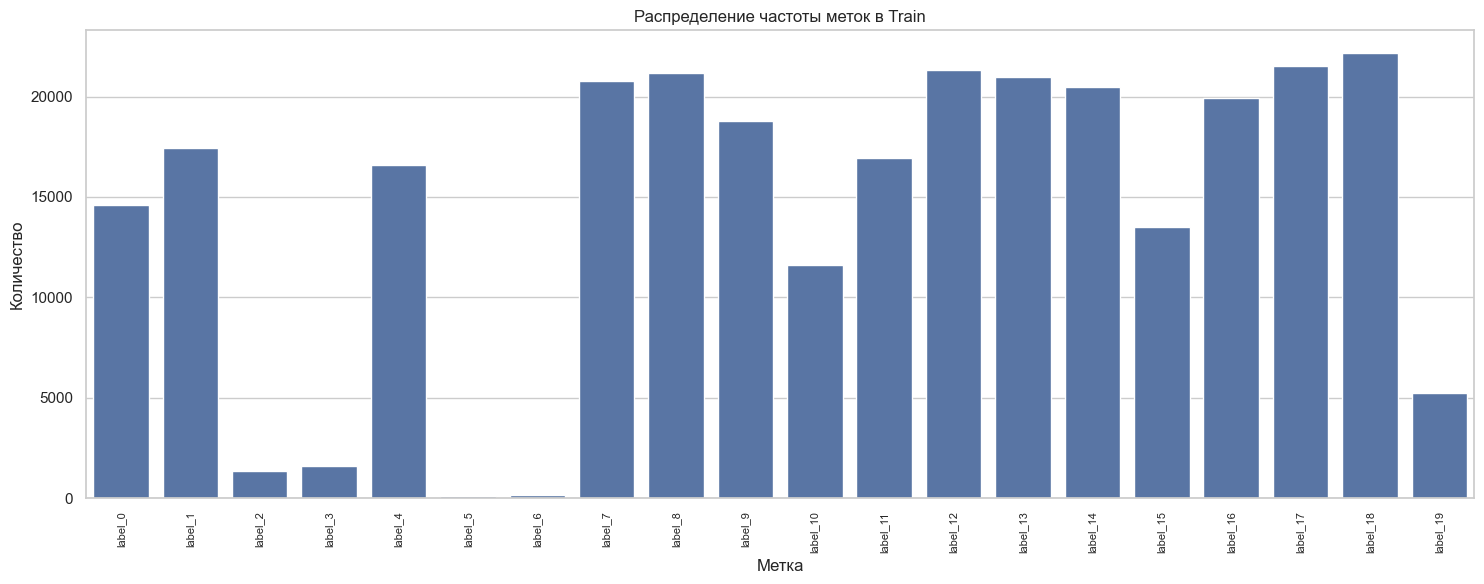

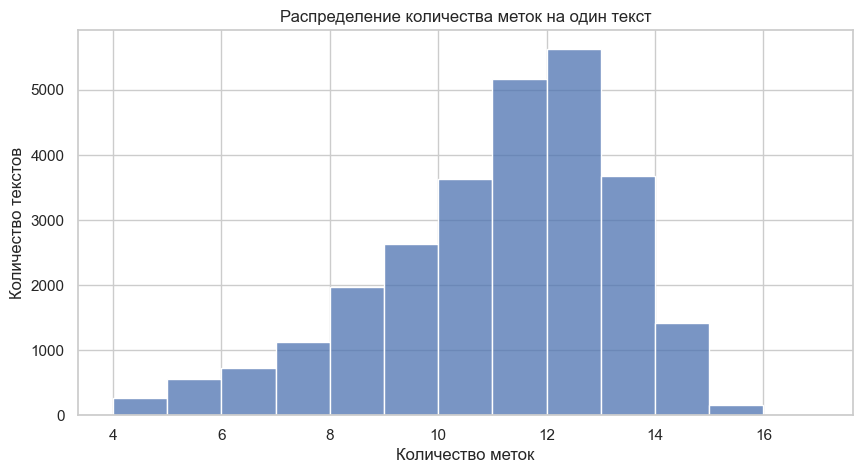

Количество текстов без меток: 0


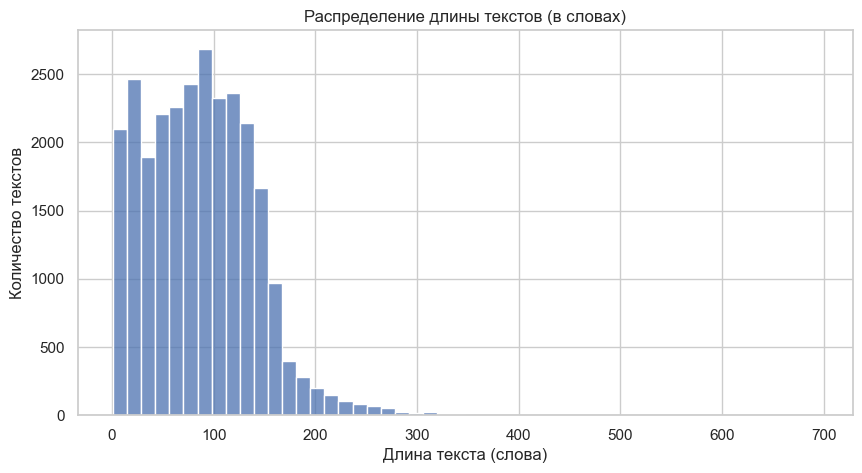

Средняя длина (слова): 87.04
Медианная длина (слова): 85.00


In [2]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")

# Проверка и удаление дубликатов текста
duplicate_texts = train_df['text'].duplicated().sum()
print(f"\nКоличество дублирующихся текстов в Train: {duplicate_texts}")
if duplicate_texts > 0:
    initial_size = len(train_df)
    train_df = train_df.drop_duplicates(subset=['text']).reset_index(drop=True)
    print(f"Размер Train до удаления дубликатов: {initial_size}")
    print(f"Размер Train после удаления дубликатов: {len(train_df)}")

print("\n3. Анализ целевых переменных (labels)...")
train_df['label_list'] = train_df['labels'].apply(lambda x: [int(i) for i in x.split()])
OUTPUT_DIM = len(train_df['label_list'].iloc[0])
print(f"Общее количество уникальных лейблов: {OUTPUT_DIM}")
y_train = np.array(train_df['label_list'].tolist())

# Баланс классов
label_counts = y_train.sum(axis=0)
label_names = np.array([f'label_{i}' for i in range(OUTPUT_DIM)])
plt.figure(figsize=(15, 6))
sns.barplot(x=label_names, y=label_counts)
plt.title('Распределение частоты меток в Train')
plt.xlabel('Метка')
plt.ylabel('Количество')
plt.xticks(rotation=90, fontsize=8); plt.tight_layout(); plt.show()

# Количество меток на текст
labels_per_text = y_train.sum(axis=1)
plt.figure(figsize=(10, 5))
sns.histplot(x=labels_per_text, bins=range(labels_per_text.min(), labels_per_text.max() + 2))
plt.title('Распределение количества меток на один текст'); plt.xlabel('Количество меток'); plt.ylabel('Количество текстов'); plt.show()
print(f"Количество текстов без меток: {(labels_per_text == 0).sum()}")

train_df['text_len_words'] = train_df['text'].astype(str).apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(data=train_df, x='text_len_words', bins=50)
plt.title('Распределение длины текстов (в словах)'); plt.xlabel('Длина текста (слова)'); plt.ylabel('Количество текстов'); plt.show()
print(f"Средняя длина (слова): {train_df['text_len_words'].mean():.2f}")
print(f"Медианная длина (слова): {train_df['text_len_words'].median():.2f}")

Есть дисбаланс классов, максимальную длинну можно ставить 200-300, один объект может относиться к 10 классам, удалил дубликаты в трейне, которые могли завышать скор на валидации и приводить к переобучению модели

## Очистка текста

In [3]:
def clean_text_for_tfidf(text, stop_words_set):
    """Очистка и лемматизация текста для TF-IDF."""
    if not isinstance(text, str): return ""
    text = text.lower()
    text = text.replace('ё', 'е')
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\+?\d[\d\s-]{7,}\d', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.replace('\n', ' ')
    translator = str.maketrans('', '', string.punctuation + '«»“”„…━')
    text = text.translate(translator)
    text = re.sub(r'\d+', ' ', text)

    words = text.split()
    lemmatized_words = []
    for word in words:
        if word and word not in stop_words_set:
            p = morph.parse(word)[0]
            lemma = p.normal_form
            if len(lemma) > 2:
                lemmatized_words.append(lemma)
    return " ".join(lemmatized_words)

def clean_text_for_sequential(text):
    """Очистка текста для Sequential моделей (W2V, RNN, CNN) - без лемматизации."""
    if not isinstance(text, str): return ""
    text = text.lower()
    text = text.replace('ё', 'е')
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\+?\d[\d\s-]{7,}\d', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.replace('\n', ' ')
    punct_to_replace_with_space = string.punctuation + '«»“”„…━'
    translator = str.maketrans(punct_to_replace_with_space, ' ' * len(punct_to_replace_with_space))
    text = text.translate(translator)
    words = text.split()
    cleaned_words = [word for word in words if len(word) > 1 or word.isdigit()]
    return " ".join(cleaned_words)

def clean_text_for_bert(text):
    """Минимальная очистка текста для BERT."""
    if not isinstance(text, str): return ""
    text = text.replace('ё', 'е')
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\+?\d[\d\s-]{7,}\d', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [4]:
tqdm.pandas(desc="Общий прогресс")

# Train Data
train_df['text_cleaned_tfidf'] = train_df['text'].progress_apply(lambda x: clean_text_for_tfidf(x, russian_stop_words))
train_df['text_cleaned_sequential'] = train_df['text'].progress_apply(clean_text_for_sequential)
train_df['text_cleaned_bert'] = train_df['text'].progress_apply(clean_text_for_bert)

# Test Data
test_df['text_cleaned_tfidf'] = test_df['text'].progress_apply(lambda x: clean_text_for_tfidf(x, russian_stop_words))
test_df['text_cleaned_sequential'] = test_df['text'].progress_apply(clean_text_for_sequential)
test_df['text_cleaned_bert'] = test_df['text'].progress_apply(clean_text_for_bert)

print("Train Data")
display(train_df[['text', 'text_cleaned_tfidf', 'text_cleaned_sequential', 'text_cleaned_bert']].head())

print("\nTest Data")
display(test_df[['text', 'text_cleaned_tfidf', 'text_cleaned_sequential', 'text_cleaned_bert']].head())


Общий прогресс:   0%|          | 0/26967 [00:00<?, ?it/s]

Общий прогресс:   0%|          | 0/26967 [00:00<?, ?it/s]

Общий прогресс:   0%|          | 0/26967 [00:00<?, ?it/s]

Общий прогресс:   0%|          | 0/7392 [00:00<?, ?it/s]

Общий прогресс:   0%|          | 0/7392 [00:00<?, ?it/s]

Общий прогресс:   0%|          | 0/7392 [00:00<?, ?it/s]

Train Data


,text,text_cleaned_tfidf,text_cleaned_sequential,text_cleaned_bert
0,15 января\nДетская развлекательная программа\n...,январь детский развлекательный программа беспл...,15 января детская развлекательная программа 15...,15 января Детская развлекательная программа 15...
1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,август выходной мег мегапарк,13 14 августа выходные меге мегапарк,13 и 14 августа Выходные в Меге Мегапарк
2,Йокнапатофа\nПостановка Театр им. Маяковского\...,йокнапатоф постановка театр маяковский билет,йокнапатофа постановка театр им маяковского би...,Йокнапатофа Постановка Театр им. Маяковского Б...
3,Впервые в Уфе танцевальная терапия в группе с ...,впервые уфа танцевальный терапия группа практи...,впервые уфе танцевальная терапия группе практи...,Впервые в Уфе танцевальная терапия в группе с ...
4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",grand piano competition друг сегодня открытие ...,grand piano competition друзья сегодня открыти...,"GRAND PIANO COMPETITION Друзья, сегодня открыт..."



Test Data


,text,text_cleaned_tfidf,text_cleaned_sequential,text_cleaned_bert
0,"ЭЙ, ВЛЮБЛЁННЫЕ\nСкидка 20% промокоду SYHOYZ\nн...",влюбить скидка промокод syhoyz спектакль ёжик ...,эй влюбленные скидка 20 промокоду syhoyz на сп...,"ЭЙ, ВЛЮБЛЁННЫЕ Скидка 20% промокоду SYHOYZ на ..."
1,Пруды Москвы,пруд москва,пруды москвы,Пруды Москвы
2,🤪\n🤪\n👏\n👏\n😄\n😄\n👏\n👏\n👨‍👩‍👦\nСемейка лёгкого...,семейка лёгкий поведение неожиданный комедия т...,семейка легкого поведения неожиданная комедия ...,Семейка легкого поведения Неожиданная комедия ...
3,24 СЕНТЯБРЯ\nИсторический фестиваль «Башкирия ...,сентябрь исторический фестиваль башкирия русь ...,24 сентября исторический фестиваль башкирия ру...,24 СЕНТЯБРЯ Исторический фестиваль «Башкирия и...
4,19-20 августа\nДетский клуб в кафе «Отдых»\nТе...,август детский клуб кафе отдых тематический ра...,19 20 августа детский клуб кафе отдых тематиче...,19-20 августа Детский клуб в кафе «Отдых» Тема...


## Разделение данных

In [5]:
X_indices = np.arange(len(train_df)).reshape(-1, 1)
X_train_idx_indices, y_train_final, X_val_idx_indices, y_val_split = iterative_train_test_split(
    X_indices, y_train, test_size=TEST_SPLIT_SIZE
)
train_indices = X_train_idx_indices.flatten()
val_indices = X_val_idx_indices.flatten()

train_split_df = train_df.iloc[train_indices].reset_index(drop=True)
val_split_df = train_df.iloc[val_indices].reset_index(drop=True)
y_val_final = y_val_split

print(f"Размер обучающей выборки (DF): {train_split_df.shape}")
print(f"Размер валидационной выборки (DF): {val_split_df.shape}")
print(f"Размер y_train_final: {y_train_final.shape}")
print(f"Размер y_val_final: {y_val_final.shape}")


Размер обучающей выборки (DF): (21545, 8)
Размер валидационной выборки (DF): (5422, 8)
Размер y_train_final: (21545, 20)
Размер y_val_final: (5422, 20)


## Определение вспомогательных функций и классов

In [6]:
# датасеты
class TfidfDataset(Dataset):
    def __init__(self, features, labels):
        if features.shape[0] != labels.shape[0]:
            raise ValueError("Mismatch features/labels")
        self.features = features
        self.labels = labels
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self, idx):
        feat = torch.tensor(self.features[idx].toarray().flatten(), dtype=torch.float32)
        lab = torch.tensor(self.labels[idx], dtype=torch.float32)
        return feat, lab

class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, max_len):
        if len(sequences) != labels.shape[0]:
            raise ValueError("Количество последовательностей не совпадает с количеством меток")
        self.sequences = sequences
        self.labels = labels
        self.max_len = max_len
        self.UNK_IDX = 1
        self.PAD_IDX = 0

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx][:self.max_len]
        if not seq:
            seq = [self.UNK_IDX]
        sequence_tensor = torch.tensor(seq, dtype=torch.long)
        label_vector = torch.tensor(self.labels[idx], dtype=torch.float32)
        return sequence_tensor, label_vector


# модели
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx, pretrained_embeddings=None, freeze_embeddings=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed_embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout_layer(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout_layer(hidden[-1,:,:])
        return self.fc(hidden)

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([nn.Conv1d(embedding_dim, n_filters, fs) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[-1]).squeeze(-1) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        return self.fc(cat)

class LSTMClassifierTrainableEmb(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, 
                            dropout=dropout if n_layers > 1 else 0, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed_embedded)
        hidden = self.dropout_layer(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)) if self.lstm.bidirectional else self.dropout_layer(hidden[-1,:,:])
        return self.fc(hidden)

In [7]:
# Функция расчета AUC
def calculate_auc(all_targets, all_preds):
    targets_np = all_targets.cpu().numpy()
    preds_np = all_preds.cpu().numpy()
    auc_scores = []
    for i in range(targets_np.shape[1]):
        if len(np.unique(targets_np[:, i])) > 1:
             try:
                 auc = roc_auc_score(targets_np[:, i], preds_np[:, i])
                 auc_scores.append(auc)
             except ValueError:
                  auc_scores.append(0.5)
        else:
             auc_scores.append(0.5)
    return np.mean(auc_scores) if auc_scores else 0.0

# Загрузка NLTK токенизатора
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    print("Загрузка NLTK токенизатора 'punkt'...")
    nltk.download('punkt')

def compute_metrics(eval_pred):
    logits, labels = eval_pred; preds = 1/(1+np.exp(-logits)); targets = labels.astype(int)
    auc_scores = []
    for i in range(targets.shape[1]):
        if len(np.unique(targets[:, i])) > 1:
            try: auc = roc_auc_score(targets[:, i], preds[:, i]); auc_scores.append(auc)
            except ValueError: auc_scores.append(0.5)
        else: auc_scores.append(0.5)
    return {"roc_auc_macro": np.mean(auc_scores) if auc_scores else 0.0}

# Функция для преобразования текста в последовательность
def text_to_sequence(text, word_to_idx_map):
    tokens = word_tokenize(str(text)) if isinstance(text, str) else []
    current_unk_idx = word_to_idx_map.get('<UNK>', 1)
    sequence = [word_to_idx_map.get(word, current_unk_idx) for word in tokens]
    if not sequence:
        return [current_unk_idx]
    return sequence

# Универсальные функции обучения и оценки
def train_loop(model, dataloader, criterion, optimizer, device, is_rnn_or_cnn=False):
    model.train()
    running_loss = 0.0
    all_targets_train = []
    all_preds_train = []
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch_data in progress_bar:
        if is_rnn_or_cnn:
            sequences, labels, lengths = batch_data
            sequences, labels = sequences.to(device), labels.to(device)
        else:
            features, labels = batch_data
            features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        if is_rnn_or_cnn == 'rnn':
            outputs = model(sequences, lengths)
        elif is_rnn_or_cnn == 'cnn':
            outputs = model(sequences)
        else:
            outputs = model(features)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * labels.size(0)
        all_preds_train.append(torch.sigmoid(outputs).detach())
        all_targets_train.append(labels.detach())
        progress_bar.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds_train = torch.cat(all_preds_train, dim=0)
    all_targets_train = torch.cat(all_targets_train, dim=0)
    
    return epoch_loss, calculate_auc(all_targets_train, all_preds_train)

def evaluate_loop(model, dataloader, criterion, device, is_rnn_or_cnn=False):
    model.eval()
    running_loss = 0.0
    all_targets_val = []
    all_preds_val = []
    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
    
    with torch.no_grad():
        for batch_data in progress_bar:
            if is_rnn_or_cnn:
                sequences, labels, lengths = batch_data
                sequences, labels = sequences.to(device), labels.to(device)
            else:
                features, labels = batch_data
                features, labels = features.to(device), labels.to(device)
            outputs = model(sequences, lengths) if is_rnn_or_cnn == 'rnn' else model(sequences) if is_rnn_or_cnn == 'cnn' else model(features)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            all_preds_val.append(torch.sigmoid(outputs))
            all_targets_val.append(labels)
            progress_bar.set_postfix(loss=loss.item())
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds_val = torch.cat(all_preds_val, dim=0)
    all_targets_val = torch.cat(all_targets_val, dim=0)
    return epoch_loss, calculate_auc(all_targets_val, all_preds_val)


def collate_batch_configurable(batch, pad_idx_value, unk_idx_value):
    sequences_raw, labels_raw = zip(*batch)
    processed_sequences = []
    for seq_tensor in sequences_raw:
        if len(seq_tensor) == 0:
            processed_sequences.append(torch.tensor([unk_idx_value], dtype=torch.long))
        else:
            processed_sequences.append(seq_tensor)

    lengths = torch.tensor([len(seq) for seq in processed_sequences], dtype=torch.long)
    padded_sequences = pad_sequence(processed_sequences, batch_first=True, padding_value=pad_idx_value)

    labels_tensor = torch.stack([
        lab if isinstance(lab, torch.Tensor) else torch.tensor(lab, dtype=torch.float32)
        for lab in labels_raw
    ], dim=0)
    return padded_sequences, labels_tensor, lengths

## TF-IDF + MLP

In [8]:
# 1. Векторизация
tfidf_vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=3, max_df=0.9)
X_train_tfidf_sparse = tfidf_vectorizer.fit_transform(train_split_df['text_cleaned_tfidf'])
X_val_tfidf_sparse = tfidf_vectorizer.transform(val_split_df['text_cleaned_tfidf'])
INPUT_DIM = X_train_tfidf_sparse.shape[1]
print(f"TF-IDF размерность: {INPUT_DIM}")

# 2. Dataset
train_dataset_tfidf = TfidfDataset(X_train_tfidf_sparse, y_train_final)
val_dataset_tfidf = TfidfDataset(X_val_tfidf_sparse, y_val_final)

# 3. DataLoader
print("Создание TF-IDF DataLoader...")
train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
DATALOADERS_CREATED_TFIDF = True

model_tfidf_nn = SimpleMLP(INPUT_DIM, HIDDEN_DIM_MLP, OUTPUT_DIM).to(device)

TF-IDF размерность: 20000
Создание TF-IDF DataLoader...



--- Эпоха 1 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.4778 | Train AUC: 0.8387
Val Loss:   0.3580 | Val AUC:   0.9070
Val AUC улучшился (-1.0000 -> 0.9070). Сохраняем...

--- Эпоха 2 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2917 | Train AUC: 0.9271
Val Loss:   0.2961 | Val AUC:   0.9283
Val AUC улучшился (0.9070 -> 0.9283). Сохраняем...

--- Эпоха 3 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2141 | Train AUC: 0.9474
Val Loss:   0.2872 | Val AUC:   0.9368
Val AUC улучшился (0.9283 -> 0.9368). Сохраняем...

--- Эпоха 4 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1753 | Train AUC: 0.9585
Val Loss:   0.2991 | Val AUC:   0.9413
Val AUC улучшился (0.9368 -> 0.9413). Сохраняем...

--- Эпоха 5 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1503 | Train AUC: 0.9665
Val Loss:   0.3235 | Val AUC:   0.9439
Val AUC улучшился (0.9413 -> 0.9439). Сохраняем...

--- Эпоха 6 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1325 | Train AUC: 0.9729
Val Loss:   0.3440 | Val AUC:   0.9456
Val AUC улучшился (0.9439 -> 0.9456). Сохраняем...

--- Эпоха 7 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1182 | Train AUC: 0.9779
Val Loss:   0.3677 | Val AUC:   0.9464
Val AUC улучшился (0.9456 -> 0.9464). Сохраняем...

--- Эпоха 8 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1064 | Train AUC: 0.9817
Val Loss:   0.3824 | Val AUC:   0.9474
Val AUC улучшился (0.9464 -> 0.9474). Сохраняем...

--- Эпоха 9 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0962 | Train AUC: 0.9848
Val Loss:   0.4004 | Val AUC:   0.9473

--- Эпоха 10 (TFIDF+MLP) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0874 | Train AUC: 0.9873
Val Loss:   0.4189 | Val AUC:   0.9472

--- Эпоха 11 (TFIDF+MLP) ---
LR: 0.000200


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0765 | Train AUC: 0.9905
Val Loss:   0.4319 | Val AUC:   0.9474
Val AUC улучшился (0.9474 -> 0.9474). Сохраняем...

--- Эпоха 12 (TFIDF+MLP) ---
LR: 0.000200


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0737 | Train AUC: 0.9912
Val Loss:   0.4373 | Val AUC:   0.9475
Val AUC улучшился (0.9474 -> 0.9475). Сохраняем...

--- Эпоха 13 (TFIDF+MLP) ---
LR: 0.000200


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0717 | Train AUC: 0.9915
Val Loss:   0.4469 | Val AUC:   0.9476
Val AUC улучшился (0.9475 -> 0.9476). Сохраняем...

--- Эпоха 14 (TFIDF+MLP) ---
LR: 0.000200


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0702 | Train AUC: 0.9919
Val Loss:   0.4499 | Val AUC:   0.9475

--- Эпоха 15 (TFIDF+MLP) ---
LR: 0.000040


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0670 | Train AUC: 0.9927
Val Loss:   0.4522 | Val AUC:   0.9475

--- Эпоха 16 (TFIDF+MLP) ---
LR: 0.000040


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0674 | Train AUC: 0.9925
Val Loss:   0.4529 | Val AUC:   0.9475
Ранняя остановка на эпохе 16.


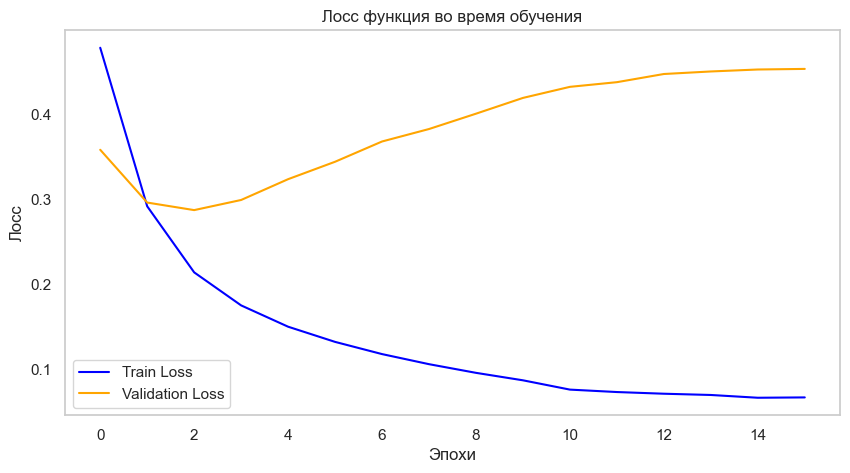

In [9]:
# 5. Обучение
num_samples = len(y_train_final)
num_positives_per_class = np.sum(y_train_final, axis=0)
num_negatives_per_class = num_samples - num_positives_per_class
pos_weight = num_negatives_per_class / (num_positives_per_class + 1e-6)
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float32).to(device)
criterion_tfidf = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor).to(device)
optimizer_tfidf = optim.AdamW(model_tfidf_nn.parameters(), lr=1e-3)
scheduler_tfidf = ReduceLROnPlateau(optimizer_tfidf, mode='max', factor=0.2, patience=1)

best_val_auc_tfidf = -1.0
early_stopping_counter_tfidf = 0
train_losses_tfidf, val_losses_tfidf, train_aucs_tfidf, val_aucs_tfidf, lr_tfidf = [], [], [], [], []

for epoch in range(20):
    print(f"\n--- Эпоха {epoch + 1} (TFIDF+MLP) ---")
    lr_tfidf.append(optimizer_tfidf.param_groups[0]['lr'])
    print(f"LR: {lr_tfidf[-1]:.6f}")

    train_loss, train_auc = train_loop(model_tfidf_nn, train_loader_tfidf, criterion_tfidf, optimizer_tfidf, device, is_rnn_or_cnn=False)
    val_loss, val_auc = evaluate_loop(model_tfidf_nn, val_loader_tfidf, criterion_tfidf, device, is_rnn_or_cnn=False)
    train_losses_tfidf.append(train_loss)
    val_losses_tfidf.append(val_loss)
    train_aucs_tfidf.append(train_auc)
    val_aucs_tfidf.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f}")

    scheduler_tfidf.step(val_auc)
    if val_auc > best_val_auc_tfidf:
        print(f"Val AUC улучшился ({best_val_auc_tfidf:.4f} -> {val_auc:.4f}). Сохраняем...")
        best_val_auc_tfidf = val_auc
        torch.save(model_tfidf_nn.state_dict(), MODEL_PATHS["tfidf_mlp"])
        early_stopping_counter_tfidf = 0
    else:
        early_stopping_counter_tfidf += 1

    if early_stopping_counter_tfidf >= EARLY_STOPPING_PATIENCE:
        print(f"Ранняя остановка на эпохе {epoch + 1}.")
        break

plt.figure(figsize=(10, 5))
plt.plot(train_losses_tfidf, label='Train Loss', color='blue')
plt.plot(val_losses_tfidf, label='Validation Loss', color='orange')
plt.title('Лосс функция во время обучения')
plt.xlabel('Эпохи')
plt.ylabel('Лосс')
plt.legend()
plt.grid()

даже при условии что довольно странно себя ведёт лосс, хотя roc auc на валидации увеличивается - скор от этого лучше на паблике \
0.835 на прайвате и 0.840 на паблике

## Word2Vec + LSTM

In [10]:
# 1. Обучение Word2Vec
sentences_for_w2v = [
    word_tokenize(str(text)) 
    for text in tqdm(train_split_df['text_cleaned_sequential']) 
    if isinstance(text, str) and text.strip()
]

w2v_model = Word2Vec(
    sentences=sentences_for_w2v, 
    vector_size=W2V_VECTOR_SIZE, 
    window=W2V_WINDOW, 
    min_count=W2V_MIN_COUNT, 
    workers=W2V_WORKERS, 
    epochs=W2V_EPOCHS, 
    sg=1, 
    seed=SEED
)

globals()['word_to_idx'] = {word: idx + 2 for idx, word in enumerate(w2v_model.wv.index_to_key)}
globals()['word_to_idx']['<PAD>'] = PAD_IDX
globals()['word_to_idx']['<UNK>'] = UNK_IDX
globals()['VOCAB_SIZE'] = len(word_to_idx)
print(f"Размер словаря Word2Vec (глобальный VOCAB_SIZE): {VOCAB_SIZE}")
print(f"Глобальный PAD_IDX: {PAD_IDX}, UNK_IDX: {UNK_IDX}")

VOCAB_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, "word_to_idx.json")
print(f"Сохранение словаря в {VOCAB_SAVE_PATH}...")
with open(VOCAB_SAVE_PATH, 'w', encoding='utf8') as f:
    json.dump(word_to_idx, f, ensure_ascii=False, indent=4)
print("Словарь сохранен.")

# 2. Создание Embedding-матрицы
embedding_matrix = np.zeros((VOCAB_SIZE, W2V_VECTOR_SIZE))
for word, idx_val in word_to_idx.items():
    if idx_val > UNK_IDX and word in w2v_model.wv:
        embedding_matrix[idx_val] = w2v_model.wv[word]
embedding_matrix[UNK_IDX] = np.random.normal(scale=0.6, size=(W2V_VECTOR_SIZE,))
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
print(f"Embedding матрица: {embedding_matrix.shape}")

# 3. Преобразование текстов в последовательности (использует глобальный word_to_idx)
train_sequences = [
    text_to_sequence(text, word_to_idx) 
    for text in tqdm(train_split_df['text_cleaned_sequential'], desc="Train Seq")
]
val_sequences = [
    text_to_sequence(text, word_to_idx) 
    for text in tqdm(val_split_df['text_cleaned_sequential'], desc="Val Seq")
]

current_notebook_pad_idx = PAD_IDX
current_notebook_unk_idx = UNK_IDX

collate_fn_for_w2v_lstm = functools.partial(
    collate_batch_configurable,
    pad_idx_value=current_notebook_pad_idx,
    unk_idx_value=current_notebook_unk_idx
)

# 4. Dataset и DataLoader
train_seq_dataset = SequenceDataset(train_sequences, y_train_final, MAX_LEN)
val_seq_dataset = SequenceDataset(val_sequences, y_val_final, MAX_LEN)
train_seq_loader = DataLoader(train_seq_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_for_w2v_lstm, num_workers=0)
val_seq_loader = DataLoader(val_seq_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_for_w2v_lstm, num_workers=0)
SEQ_DATALOADERS_CREATED = True

model_w2v_lstm = LSTMClassifier(VOCAB_SIZE, W2V_VECTOR_SIZE, LSTM_HIDDEN_DIM, OUTPUT_DIM, LSTM_LAYERS, LSTM_BIDIRECTIONAL, LSTM_DROPOUT, PAD_IDX, embedding_matrix, FREEZE_EMBEDDINGS).to(device)

  0%|          | 0/21545 [00:00<?, ?it/s]

Размер словаря Word2Vec (глобальный VOCAB_SIZE): 39759
Глобальный PAD_IDX: 0, UNK_IDX: 1
Сохранение словаря в ./trained_models/word_to_idx.json...
Словарь сохранен.
Embedding матрица: torch.Size([39759, 300])


Train Seq:   0%|          | 0/21545 [00:00<?, ?it/s]

Val Seq:   0%|          | 0/5422 [00:00<?, ?it/s]

Запуск обучения W2V+LSTM...
Ограниченные pos_weight для LSTM (train): tensor([ 0.8408,  0.5454, 19.3063, 15.7145,  0.6254, 20.0000, 20.0000,  0.3005,
         0.2712,  0.4368,  1.3227,  0.5984,  0.2628,  0.2880,  0.3123,  0.9955,
         0.3535,  0.2542,  0.2142,  4.1592], device='mps:0')

--- Эпоха 1 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.4229 | Train AUC: 0.7807
Val Loss:   0.3183 | Val AUC:   0.8856
Val AUC улучшился (-1.0000 -> 0.8856). Сохраняем...

--- Эпоха 2 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2937 | Train AUC: 0.8915
Val Loss:   0.2781 | Val AUC:   0.9076
Val AUC улучшился (0.8856 -> 0.9076). Сохраняем...

--- Эпоха 3 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2371 | Train AUC: 0.9190
Val Loss:   0.2765 | Val AUC:   0.9140
Val AUC улучшился (0.9076 -> 0.9140). Сохраняем...

--- Эпоха 4 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1987 | Train AUC: 0.9348
Val Loss:   0.3037 | Val AUC:   0.9157
Val AUC улучшился (0.9140 -> 0.9157). Сохраняем...

--- Эпоха 5 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1774 | Train AUC: 0.9435
Val Loss:   0.3081 | Val AUC:   0.9153

--- Эпоха 6 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1596 | Train AUC: 0.9507
Val Loss:   0.3489 | Val AUC:   0.9201
Val AUC улучшился (0.9157 -> 0.9201). Сохраняем...

--- Эпоха 7 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1450 | Train AUC: 0.9569
Val Loss:   0.3390 | Val AUC:   0.9219
Val AUC улучшился (0.9201 -> 0.9219). Сохраняем...

--- Эпоха 8 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1340 | Train AUC: 0.9618
Val Loss:   0.3443 | Val AUC:   0.9236
Val AUC улучшился (0.9219 -> 0.9236). Сохраняем...

--- Эпоха 9 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1241 | Train AUC: 0.9656
Val Loss:   0.3792 | Val AUC:   0.9253
Val AUC улучшился (0.9236 -> 0.9253). Сохраняем...

--- Эпоха 10 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1143 | Train AUC: 0.9694
Val Loss:   0.4000 | Val AUC:   0.9248

--- Эпоха 11 (W2V+LSTM) ---
LR: 0.000500


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1084 | Train AUC: 0.9718
Val Loss:   0.4007 | Val AUC:   0.9245

--- Эпоха 12 (W2V+LSTM) ---
LR: 0.000100


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0951 | Train AUC: 0.9765
Val Loss:   0.4171 | Val AUC:   0.9263
Val AUC улучшился (0.9253 -> 0.9263). Сохраняем...

--- Эпоха 13 (W2V+LSTM) ---
LR: 0.000100


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0891 | Train AUC: 0.9781
Val Loss:   0.4308 | Val AUC:   0.9262

--- Эпоха 14 (W2V+LSTM) ---
LR: 0.000100


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0855 | Train AUC: 0.9792
Val Loss:   0.4421 | Val AUC:   0.9262

--- Эпоха 15 (W2V+LSTM) ---
LR: 0.000020


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0818 | Train AUC: 0.9803
Val Loss:   0.4447 | Val AUC:   0.9262
Ранняя остановка на эпохе 15.


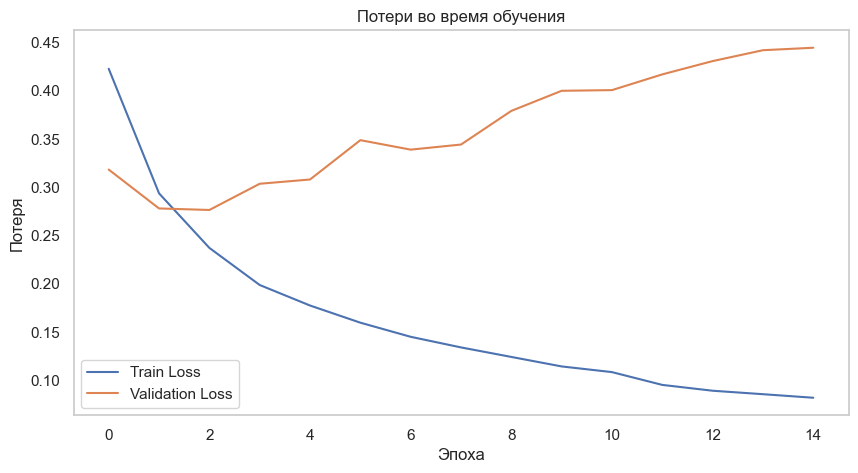

In [11]:
# 6. Обучение
print("Запуск обучения W2V+LSTM...")

# Подсчет количества образцов и классов
num_samples_train = len(y_train_final)
num_positives_per_class_train = np.sum(y_train_final, axis=0)
num_negatives_per_class_train = num_samples_train - num_positives_per_class_train

# Вычисление веса для положительного класса
pos_weight_train = num_negatives_per_class_train / (num_positives_per_class_train + 1e-6)
pos_weight_train_tensor = torch.tensor(pos_weight_train, dtype=torch.float32).to(device)
pos_weight_train_tensor_clipped = torch.clamp(pos_weight_train_tensor, max=MAX_POS_WEIGHT)

print(f"Ограниченные pos_weight для LSTM (train): {pos_weight_train_tensor_clipped}")

criterion_w2v = nn.BCEWithLogitsLoss(pos_weight=pos_weight_train_tensor_clipped).to(device)
optimizer_w2v = optim.AdamW(model_w2v_lstm.parameters(), lr=5e-4)
scheduler_w2v = ReduceLROnPlateau(optimizer_w2v, mode='max', factor=0.2, patience=1)

best_val_auc_w2v = -1.0
early_stopping_counter_w2v = 0
train_losses_w2v, val_losses_w2v, train_aucs_w2v, val_aucs_w2v, lr_w2v = [], [], [], [], []

for epoch in range(20):
    print(f"\n--- Эпоха {epoch + 1} (W2V+LSTM) ---")
    lr_w2v.append(optimizer_w2v.param_groups[0]['lr'])
    print(f"LR: {lr_w2v[-1]:.6f}")

    train_loss, train_auc = train_loop(model_w2v_lstm, train_seq_loader, criterion_w2v, optimizer_w2v, device, is_rnn_or_cnn='rnn')
    val_loss, val_auc = evaluate_loop(model_w2v_lstm, val_seq_loader, criterion_w2v, device, is_rnn_or_cnn='rnn')

    train_losses_w2v.append(train_loss)
    val_losses_w2v.append(val_loss)
    train_aucs_w2v.append(train_auc)
    val_aucs_w2v.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f}")

    scheduler_w2v.step(val_auc)

    if val_auc > best_val_auc_w2v:
        print(f"Val AUC улучшился ({best_val_auc_w2v:.4f} -> {val_auc:.4f}). Сохраняем...")
        best_val_auc_w2v = val_auc
        torch.save(model_w2v_lstm.state_dict(), MODEL_PATHS["w2v_lstm"])
        early_stopping_counter_w2v = 0
    else:
        early_stopping_counter_w2v += 1

    # Проверка на раннюю остановку
    if early_stopping_counter_w2v >= EARLY_STOPPING_PATIENCE:
        print(f"Ранняя остановка на эпохе {epoch + 1}.")
        break

plt.figure(figsize=(10, 5))
plt.plot(train_losses_w2v, label='Train Loss')
plt.plot(val_losses_w2v, label='Validation Loss')
plt.title('Потери во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid()
plt.show()

## CNN + Trainable Emb

--- Этап 3 (Пайплайн 3): CNN + Trainable Emb (с взвешиванием классов) ---
Запуск обучения CNN+Emb (с взвешиванием классов)...
ОГРАНИЧЕННЫЕ pos_weight для CNN: tensor([ 0.8408,  0.5454, 19.3063, 15.7145,  0.6254, 20.0000, 20.0000,  0.3005,
         0.2712,  0.4368,  1.3227,  0.5984,  0.2628,  0.2880,  0.3123,  0.9955,
         0.3535,  0.2542,  0.2142,  4.1592], device='mps:0')

--- Эпоха 1 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.4499 | Train AUC: 0.7487
Val Loss:   0.3198 | Val AUC:   0.8778
Val AUC улучшился (-1.0000 -> 0.8778). Сохраняем...

--- Эпоха 2 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.3359 | Train AUC: 0.8640
Val Loss:   0.2773 | Val AUC:   0.9199
Val AUC улучшился (0.8778 -> 0.9199). Сохраняем...

--- Эпоха 3 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2976 | Train AUC: 0.8928
Val Loss:   0.2599 | Val AUC:   0.9290
Val AUC улучшился (0.9199 -> 0.9290). Сохраняем...

--- Эпоха 4 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2695 | Train AUC: 0.9075
Val Loss:   0.2635 | Val AUC:   0.9319
Val AUC улучшился (0.9290 -> 0.9319). Сохраняем...

--- Эпоха 5 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2495 | Train AUC: 0.9162
Val Loss:   0.2527 | Val AUC:   0.9349
Val AUC улучшился (0.9319 -> 0.9349). Сохраняем...

--- Эпоха 6 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2327 | Train AUC: 0.9229
Val Loss:   0.2554 | Val AUC:   0.9363
Val AUC улучшился (0.9349 -> 0.9363). Сохраняем...

--- Эпоха 7 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2196 | Train AUC: 0.9289
Val Loss:   0.2586 | Val AUC:   0.9374
Val AUC улучшился (0.9363 -> 0.9374). Сохраняем...

--- Эпоха 8 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2038 | Train AUC: 0.9351
Val Loss:   0.2722 | Val AUC:   0.9392
Val AUC улучшился (0.9374 -> 0.9392). Сохраняем...

--- Эпоха 9 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1952 | Train AUC: 0.9398
Val Loss:   0.2577 | Val AUC:   0.9394
Val AUC улучшился (0.9392 -> 0.9394). Сохраняем...

--- Эпоха 10 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1859 | Train AUC: 0.9437
Val Loss:   0.2762 | Val AUC:   0.9399
Val AUC улучшился (0.9394 -> 0.9399). Сохраняем...

--- Эпоха 11 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1761 | Train AUC: 0.9477
Val Loss:   0.3088 | Val AUC:   0.9397

--- Эпоха 12 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1688 | Train AUC: 0.9514
Val Loss:   0.3132 | Val AUC:   0.9401
Val AUC улучшился (0.9399 -> 0.9401). Сохраняем...

--- Эпоха 13 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1610 | Train AUC: 0.9544
Val Loss:   0.2965 | Val AUC:   0.9407
Val AUC улучшился (0.9401 -> 0.9407). Сохраняем...

--- Эпоха 14 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1550 | Train AUC: 0.9569
Val Loss:   0.3186 | Val AUC:   0.9406

--- Эпоха 15 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1485 | Train AUC: 0.9600
Val Loss:   0.3159 | Val AUC:   0.9406

--- Эпоха 16 (CNN+Emb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1414 | Train AUC: 0.9624
Val Loss:   0.3721 | Val AUC:   0.9400
Ранняя остановка на эпохе 16.

Обучение CNN+Emb завершено.
Лучшая сохраненная модель CNN+Emb имела Val AUC: 0.9407


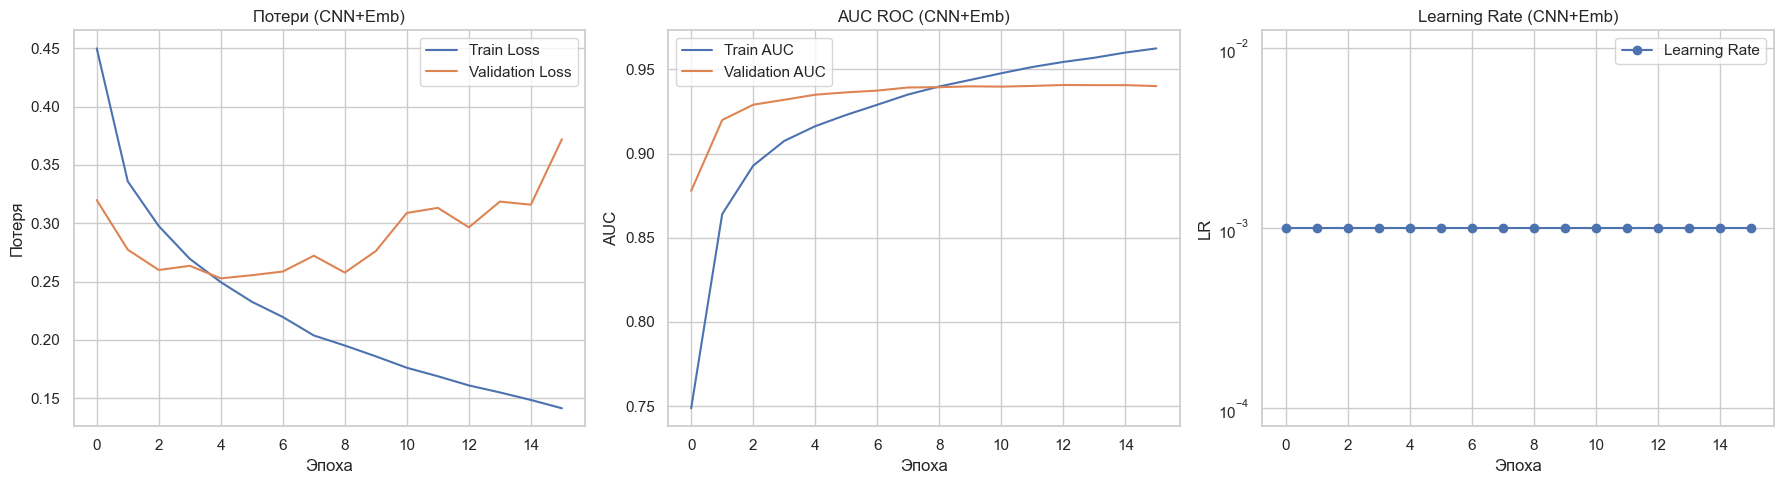

In [12]:
print("--- Этап 3 (Пайплайн 3): CNN + Trainable Emb (с взвешиванием классов) ---")

model_cnn = TextCNN(VOCAB_SIZE, CNN_EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, CNN_DROPOUT, PAD_IDX).to(device)

print("Запуск обучения CNN+Emb (с взвешиванием классов)...")

num_samples_cnn = len(y_train_final)
num_positives_per_class_cnn = np.sum(y_train_final, axis=0)
num_negatives_per_class_cnn = num_samples_cnn - num_positives_per_class_cnn
pos_weight_cnn_raw = num_negatives_per_class_cnn / (num_positives_per_class_cnn + 1e-6)

pos_weight_cnn_clipped = np.clip(pos_weight_cnn_raw, None, MAX_POS_WEIGHT)
pos_weight_tensor_cnn = torch.tensor(pos_weight_cnn_clipped, dtype=torch.float32).to(device)
print(f"ОГРАНИЧЕННЫЕ pos_weight для CNN: {pos_weight_tensor_cnn}")

criterion_cnn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor_cnn).to(device)

optimizer_cnn = optim.AdamW(model_cnn.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_cnn = ReduceLROnPlateau(optimizer_cnn, mode='max', factor=0.2, patience=2, threshold=0.0001, threshold_mode='abs')

best_val_auc_cnn = -1.0
early_stopping_counter_cnn = 0

train_losses_cnn, val_losses_cnn, train_aucs_cnn, val_aucs_cnn, lr_cnn = [], [], [], [], []

MAX_EPOCHS_CNN = 20

for epoch in range(MAX_EPOCHS_CNN):
    print(f"\n--- Эпоха {epoch + 1} (CNN+Emb) ---")
    lr_cnn.append(optimizer_cnn.param_groups[0]['lr'])
    print(f"LR: {lr_cnn[-1]:.6f}")

    train_loss, train_auc = train_loop(model_cnn, train_seq_loader, criterion_cnn, optimizer_cnn, device, is_rnn_or_cnn='cnn')
    val_loss, val_auc = evaluate_loop(model_cnn, val_seq_loader, criterion_cnn, device, is_rnn_or_cnn='cnn')
    
    train_losses_cnn.append(train_loss)
    val_losses_cnn.append(val_loss)
    train_aucs_cnn.append(train_auc)
    val_aucs_cnn.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f}")

    scheduler_cnn.step(val_auc)

    if val_auc > best_val_auc_cnn:
        print(f"Val AUC улучшился ({best_val_auc_cnn:.4f} -> {val_auc:.4f}). Сохраняем...")
        best_val_auc_cnn = val_auc
        torch.save(model_cnn.state_dict(), MODEL_PATHS["cnn_emb"])
        early_stopping_counter_cnn = 0
    else:
        early_stopping_counter_cnn += 1

    # Альтернативная ранняя остановка по Val Loss
    # if val_loss < best_val_loss_cnn - 0.0001: # Считаем улучшением, если лосс упал хотя бы на немного
    #     print(f"Val Loss улучшился ({best_val_loss_cnn:.4f} -> {val_loss:.4f}). Val AUC: {val_auc:.4f}. Сохраняем...")
    #     best_val_loss_cnn = val_loss
    #     best_val_auc_at_best_loss_cnn = val_auc
    #     torch.save(model_cnn.state_dict(), MODEL_PATHS["cnn_emb"])
    #     early_stopping_counter_cnn = 0
    # else:
    #     early_stopping_counter_cnn += 1
    #     print(f"Val Loss не улучшился или улучшился незначительно. Счетчик ранней остановки: {early_stopping_counter_cnn}.")


    if early_stopping_counter_cnn >= EARLY_STOPPING_PATIENCE:
        print(f"Ранняя остановка на эпохе {epoch + 1}.")
        # if best_val_auc_at_best_loss_cnn != -1.0: # Если останавливались по лоссу
        #     print(f"Лучший Val AUC, достигнутый при лучшем Val Loss ({best_val_loss_cnn:.4f}), был: {best_val_auc_at_best_loss_cnn:.4f}")
        break

print("\nОбучение CNN+Emb завершено.")
if best_val_auc_cnn != -1.0:
     print(f"Лучшая сохраненная модель CNN+Emb имела Val AUC: {best_val_auc_cnn:.4f}")

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses_cnn, label='Train Loss')
plt.plot(val_losses_cnn, label='Validation Loss')
plt.title('Потери (CNN+Emb)')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_aucs_cnn, label='Train AUC')
plt.plot(val_aucs_cnn, label='Validation AUC')
plt.title('AUC ROC (CNN+Emb)')
plt.xlabel('Эпоха')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(lr_cnn, label='Learning Rate', marker='o')
plt.title('Learning Rate (CNN+Emb)')
plt.xlabel('Эпоха')
plt.ylabel('LR'); plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## LSTM + Trainable Emb

Запуск обучения LSTM+TrainableEmb...

--- Эпоха 1 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.3476 | Train AUC: 0.8154
Val Loss:   0.2688 | Val AUC:   0.8999
Val AUC улучшился (-1.0000 -> 0.8999). Сохраняем...

--- Эпоха 2 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2491 | Train AUC: 0.9046
Val Loss:   0.2349 | Val AUC:   0.9180
Val AUC улучшился (0.8999 -> 0.9180). Сохраняем...

--- Эпоха 3 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2237 | Train AUC: 0.9228
Val Loss:   0.2217 | Val AUC:   0.9276
Val AUC улучшился (0.9180 -> 0.9276). Сохраняем...

--- Эпоха 4 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1997 | Train AUC: 0.9388
Val Loss:   0.2151 | Val AUC:   0.9321
Val AUC улучшился (0.9276 -> 0.9321). Сохраняем...

--- Эпоха 5 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1798 | Train AUC: 0.9492
Val Loss:   0.2057 | Val AUC:   0.9371
Val AUC улучшился (0.9321 -> 0.9371). Сохраняем...

--- Эпоха 6 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1621 | Train AUC: 0.9583
Val Loss:   0.2054 | Val AUC:   0.9397
Val AUC улучшился (0.9371 -> 0.9397). Сохраняем...

--- Эпоха 7 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1458 | Train AUC: 0.9656
Val Loss:   0.2051 | Val AUC:   0.9413
Val AUC улучшился (0.9397 -> 0.9413). Сохраняем...

--- Эпоха 8 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1317 | Train AUC: 0.9709
Val Loss:   0.2076 | Val AUC:   0.9428
Val AUC улучшился (0.9413 -> 0.9428). Сохраняем...

--- Эпоха 9 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1181 | Train AUC: 0.9767
Val Loss:   0.2055 | Val AUC:   0.9442
Val AUC улучшился (0.9428 -> 0.9442). Сохраняем...

--- Эпоха 10 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1051 | Train AUC: 0.9812
Val Loss:   0.2118 | Val AUC:   0.9435

--- Эпоха 11 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0946 | Train AUC: 0.9848
Val Loss:   0.2155 | Val AUC:   0.9445
Val AUC улучшился (0.9442 -> 0.9445). Сохраняем...

--- Эпоха 12 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0856 | Train AUC: 0.9874
Val Loss:   0.2243 | Val AUC:   0.9434

--- Эпоха 13 (LSTM+TrainableEmb) ---
LR: 0.001000


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0776 | Train AUC: 0.9899
Val Loss:   0.2352 | Val AUC:   0.9431

--- Эпоха 14 (LSTM+TrainableEmb) ---
LR: 0.000200


Training:   0%|          | 0/337 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0630 | Train AUC: 0.9936
Val Loss:   0.2339 | Val AUC:   0.9442
Ранняя остановка на эпохе 14.


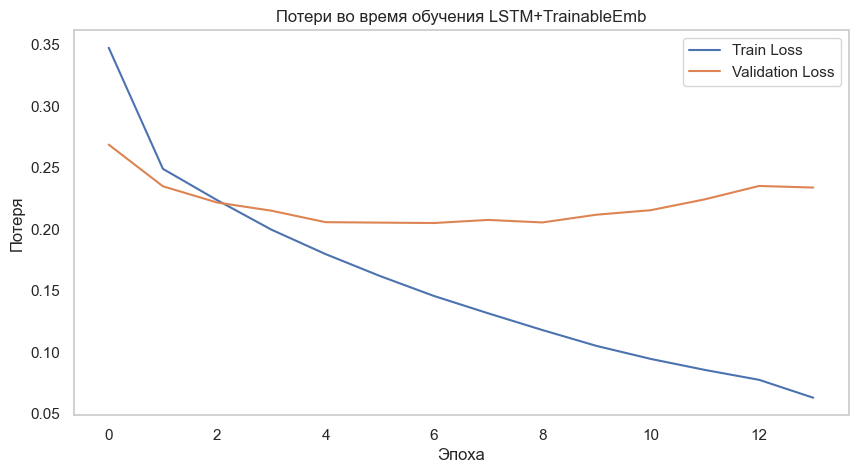


Обучение LSTM+TrainableEmb завершено.


In [13]:
model_rnn_te = LSTMClassifierTrainableEmb(VOCAB_SIZE, RNN_TE_EMBEDDING_DIM, RNN_TE_HIDDEN_DIM, 
                                           OUTPUT_DIM, RNN_TE_LAYERS, RNN_TE_BIDIRECTIONAL, 
                                           RNN_TE_DROPOUT, PAD_IDX).to(device)

# Обучение
print("Запуск обучения LSTM+TrainableEmb...")
criterion_rnn_te = nn.BCEWithLogitsLoss().to(device)
optimizer_rnn_te = optim.AdamW(model_rnn_te.parameters(), lr=1e-3)
scheduler_rnn_te = ReduceLROnPlateau(optimizer_rnn_te, mode='max', factor=0.2, patience=1)

best_val_auc_rnn_te = -1.0
early_stopping_counter_rnn_te = 0
train_losses_rnn_te, val_losses_rnn_te, train_aucs_rnn_te, val_aucs_rnn_te, lr_rnn_te = [], [], [], [], []

for epoch in range(20): 
    print(f"\n--- Эпоха {epoch + 1} (LSTM+TrainableEmb) ---")
    lr_rnn_te.append(optimizer_rnn_te.param_groups[0]['lr'])
    print(f"LR: {lr_rnn_te[-1]:.6f}")

    train_loss, train_auc = train_loop(model_rnn_te, train_seq_loader, criterion_rnn_te, optimizer_rnn_te, device, is_rnn_or_cnn='rnn')
    val_loss, val_auc = evaluate_loop(model_rnn_te, val_seq_loader, criterion_rnn_te, device, is_rnn_or_cnn='rnn')
    train_losses_rnn_te.append(train_loss)
    val_losses_rnn_te.append(val_loss)
    train_aucs_rnn_te.append(train_auc)
    val_aucs_rnn_te.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f}")

    scheduler_rnn_te.step(val_auc)
    if val_auc > best_val_auc_rnn_te:
        print(f"Val AUC улучшился ({best_val_auc_rnn_te:.4f} -> {val_auc:.4f}). Сохраняем...")
        best_val_auc_rnn_te = val_auc
        torch.save(model_rnn_te.state_dict(), MODEL_PATHS["rnn_emb"])
        early_stopping_counter_rnn_te = 0
    else:
        early_stopping_counter_rnn_te += 1

    if early_stopping_counter_rnn_te >= EARLY_STOPPING_PATIENCE:
        print(f"Ранняя остановка на эпохе {epoch + 1}.")
        break

# График потерь
plt.figure(figsize=(10, 5))
plt.plot(train_losses_rnn_te, label='Train Loss')
plt.plot(val_losses_rnn_te, label='Validation Loss')
plt.title('Потери во время обучения LSTM+TrainableEmb')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid()
plt.show()

print("\nОбучение LSTM+TrainableEmb завершено.")

## cointegrated/rubert-tiny2 (BERT)

In [17]:
# 1. Модель и токенизатор
print(f"Загрузка токенизатора и модели: {MODEL_NAME_BERT_TINY}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_BERT_TINY)
model_bert = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_BERT_TINY,
    num_labels=OUTPUT_DIM,
    problem_type="multi_label_classification"
).to(device)

TOKENIZER_LOADED = True
MODEL_LOADED = True
print("Модель и токенизатор BERT загружены.")

# 2. Подготовка данных
print("Подготовка HF Datasets и токенизация...")
TEXT_COLUMN = 'text_cleaned_bert'

def tokenize_function(examples):
    return tokenizer(examples[TEXT_COLUMN], padding="max_length", truncation=True, max_length=BERT_MAX_LEN)

train_labels_float = [list(map(float, row)) for row in y_train_final]
val_labels_float = [list(map(float, row)) for row in y_val_final]

train_dict = {
    'id': train_split_df['id'].tolist(),
    TEXT_COLUMN: train_split_df[TEXT_COLUMN].tolist(),
    'labels': train_labels_float
}

val_dict = {
    'id': val_split_df['id'].tolist(),
    TEXT_COLUMN: val_split_df[TEXT_COLUMN].tolist(),
    'labels': val_labels_float
}

hg_train_dataset = HFDataset.from_dict(train_dict)
hg_val_dataset = HFDataset.from_dict(val_dict)

tokenized_train_dataset = hg_train_dataset.map(tokenize_function, batched=True, remove_columns=[TEXT_COLUMN, "id"])
tokenized_val_dataset = hg_val_dataset.map(tokenize_function, batched=True, remove_columns=[TEXT_COLUMN, "id"])

tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
BERT_DATA_READY = True
print("Данные для BERT готовы.")

# 3. Настройка Trainer
print("Настройка Trainer...")

if len(tokenized_train_dataset) > 0 and BERT_TINY_BATCH_SIZE > 0: # <--- ИЗМЕНЕНО
    steps_per_epoch = math.ceil(len(tokenized_train_dataset) / BERT_TINY_BATCH_SIZE) # <--- ИЗМЕНЕНО
    logging_steps = max(1, steps_per_epoch // 10)
else:
    logging_steps = 50
print(f"Шаг логирования для rubert-tiny2: {logging_steps}")

training_args_tiny = TrainingArguments(
    output_dir=OUTPUT_DIR_BERT_TINY,
    num_train_epochs=BERT_TINY_EPOCHS,
    per_device_train_batch_size=BERT_TINY_BATCH_SIZE,
    learning_rate=BERT_TINY_LR,
    weight_decay=0.01,
    logging_dir=f"{OUTPUT_DIR_BERT_TINY}/logs",
    logging_steps=logging_steps,
    report_to="none",
    dataloader_num_workers=0,
)

trainer_tiny = Trainer(
    model=model_bert,
    args=training_args_tiny,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)
print("trainer_tiny создан.")

Загрузка токенизатора и модели: cointegrated/rubert-tiny2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель и токенизатор BERT загружены.
Подготовка HF Datasets и токенизация...


Map:   0%|          | 0/21545 [00:00<?, ? examples/s]

Map:   0%|          | 0/5422 [00:00<?, ? examples/s]

Данные для BERT готовы.
Настройка Trainer...
Шаг логирования для rubert-tiny2: 134
trainer_tiny создан.


In [18]:
# Обучение BERT
print("Запуск обучения BERT...")
train_results_tiny = trainer_tiny.train()
print("Обучение BERT завершено.")

# Оценка и сохранение ПОСЛЕДНЕЙ модели
print("Оценка лучшей модели rubert-tiny2...")
eval_results_tiny = trainer_tiny.evaluate()
print(eval_results_tiny)
print(f"Сохранение лучшей модели rubert-tiny2 в {MODEL_PATHS['bert_tiny']}...")
trainer_tiny.save_model(MODEL_PATHS['bert_tiny'])
if TOKENIZER_LOADED:
    tokenizer.save_pretrained(MODEL_PATHS['bert_tiny'])
print("Сохранение лучшей модели rubert-tiny2 завершено.")

Запуск обучения BERT...


Step,Training Loss
134,0.576600
268,0.441600
402,0.381000
536,0.356000
670,0.336200
804,0.334600
938,0.325800
1072,0.307900
1206,0.299700
1340,0.296000


/Users/maksimlyara/miniconda3/envs/hw2_dl_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maksimlyara/miniconda3/envs/hw2_dl_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maksimlyara/miniconda3/envs/hw2_dl_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maksimlyara/miniconda3/envs/hw2_dl_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be 

Обучение BERT завершено.
Оценка лучшей модели rubert-tiny2...


/Users/maksimlyara/miniconda3/envs/hw2_dl_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.23153647780418396, 'eval_roc_auc_macro': 0.9063949646199478, 'eval_runtime': 13.9693, 'eval_samples_per_second': 388.135, 'eval_steps_per_second': 48.535, 'epoch': 5.0}
Сохранение лучшей модели rubert-tiny2 в ./trained_models/bert_tiny_final_model...
Сохранение лучшей модели rubert-tiny2 завершено.


In [19]:
# --- Очистка памяти ПОСЛЕ сохранения ---
print("Очистка памяти после обучения rubert-tiny2...")
del model_bert # Удаляем модель из памяти
del trainer_tiny # Удаляем Trainer
if 'training_args_tiny' in locals(): del training_args_tiny
if 'train_results_tiny' in locals(): del train_results_tiny
if 'eval_results_tiny' in locals(): del eval_results_tiny
if 'loss_values_plot' in locals(): del loss_values_plot # Если создавали

if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
print("Память очищена.")

Очистка памяти после обучения rubert-tiny2...
Память очищена.


## sergeyzh/BERTA (BERT)

In [20]:
MODEL_PATHS["berta_classifier_v1"] = os.path.join(MODEL_SAVE_DIR, "berta_v1_final_model")

print(f"Загрузка токенизатора и модели: {MODEL_NAME_BERTA_V1}")
tokenizer_berta_v1 = AutoTokenizer.from_pretrained(MODEL_NAME_BERTA_V1)
model_berta_v1 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_BERTA_V1,
    num_labels=OUTPUT_DIM,
    problem_type="multi_label_classification"
).to(device)

print(f"Токенизатор и модель BERTA ({MODEL_NAME_BERTA_V1}) загружены.")
print(f"BERTA (V1): реальный батч = {BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE}, "
      f"накопление = {BERTA_V1_GRAD_ACCUM_STEPS}, "
      f"макс.длина = {BERTA_V1_MAX_LEN}")

print("Подготовка HF Datasets и токенизация для BERTA (V1)...")
TEXT_COLUMN_BERT = 'text_cleaned_bert'

def tokenize_function_berta_v1(examples):
    return tokenizer_berta_v1(
        examples[TEXT_COLUMN_BERT], padding="max_length", truncation=True,
        max_length=BERTA_V1_MAX_LEN
    )

train_labels_float_berta_v1 = [list(map(float, row)) for row in y_train_final]
val_labels_float_berta_v1 = [list(map(float, row)) for row in y_val_final]
train_dict_berta_v1 = {'id': train_split_df['id'].tolist(), TEXT_COLUMN_BERT: train_split_df[TEXT_COLUMN_BERT].tolist(), 'labels': train_labels_float_berta_v1}
val_dict_berta_v1 = {'id': val_split_df['id'].tolist(), TEXT_COLUMN_BERT: val_split_df[TEXT_COLUMN_BERT].tolist(), 'labels': val_labels_float_berta_v1}

hg_train_dataset_berta_v1 = HFDataset.from_dict(train_dict_berta_v1)
hg_val_dataset_berta_v1 = HFDataset.from_dict(val_dict_berta_v1)

tokenized_train_dataset_berta_v1 = hg_train_dataset_berta_v1.map(tokenize_function_berta_v1, batched=True, remove_columns=[TEXT_COLUMN_BERT, "id"])
tokenized_val_dataset_berta_v1 = hg_val_dataset_berta_v1.map(tokenize_function_berta_v1, batched=True, remove_columns=[TEXT_COLUMN_BERT, "id"])

tokenized_train_dataset_berta_v1.set_format("torch")
tokenized_val_dataset_berta_v1.set_format("torch")
print("Данные для BERTA (V1) готовы.")

os.makedirs(OUTPUT_DIR_BERTA_V1, exist_ok=True)

update_steps_per_epoch_berta_v1 = math.ceil(len(tokenized_train_dataset_berta_v1) / (BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE * BERTA_V1_GRAD_ACCUM_STEPS))
logging_steps_berta_v1 = max(1, update_steps_per_epoch_berta_v1 // 10)
effective_eval_steps_v1 = update_steps_per_epoch_berta_v1
effective_save_steps_v1 = update_steps_per_epoch_berta_v1

print(f"Шаг логирования BERTA (V1): {logging_steps_berta_v1}")
print(f"Шаг оценки BERTA (V1) (eval_steps): {effective_eval_steps_v1}")
print(f"Шаг сохранения BERTA (V1) (save_steps): {effective_save_steps_v1}")

training_args_berta_v1 = TrainingArguments(
    output_dir=OUTPUT_DIR_BERTA_V1,
    num_train_epochs=BERTA_V1_EPOCHS,
    per_device_train_batch_size=BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE,
    per_device_eval_batch_size=BERTA_V1_REAL_BATCH_SIZE_PER_DEVICE * 2,
    gradient_accumulation_steps=BERTA_V1_GRAD_ACCUM_STEPS,
    learning_rate=BERTA_V1_LR,
    weight_decay=0.01,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=effective_eval_steps_v1,
    save_steps=effective_save_steps_v1,
    do_eval=True,
    logging_strategy="steps",
    logging_steps=logging_steps_berta_v1,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc_macro",
    greater_is_better=True,
    report_to="none",
    dataloader_num_workers=0,
    save_total_limit=2,
    fp16=False,
)

print("TrainingArguments для BERTA (V1) созданы успешно!")

trainer_berta_v1 = Trainer(
    model=model_berta_v1,
    args=training_args_berta_v1,
    train_dataset=tokenized_train_dataset_berta_v1,
    eval_dataset=tokenized_val_dataset_berta_v1,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer_berta_v1
)
print("Trainer для BERTA (V1) создан.")

# --- 4. Обучение BERTA (V1) ---
print("Запуск обучения BERTA (V1)...")
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

try:
    train_result_berta_v1 = trainer_berta_v1.train() # Новая переменная для результатов
    print("Обучение BERTA (V1) завершено.")
    trainer_berta_v1.save_metrics("train", train_result_berta_v1.metrics)
except Exception as e:
    print(f"Ошибка во время обучения BERTA (V1): {e}")
    raise

print("Оценка лучшей модели BERTA (V1) на валидационном наборе...")
eval_results_berta_v1 = trainer_berta_v1.evaluate(eval_dataset=tokenized_val_dataset_berta_v1)
print("Результаты оценки BERTA (V1):")
print(eval_results_berta_v1)
trainer_berta_v1.save_metrics("eval", eval_results_berta_v1)

save_path_berta_v1 = MODEL_PATHS["berta_classifier_v1"]
print(f"Сохранение лучшей модели BERTA (V1) в {save_path_berta_v1}...")
trainer_berta_v1.save_model(save_path_berta_v1)
tokenizer_berta_v1.save_pretrained(save_path_berta_v1)
print("Сохранение лучшей модели BERTA (V1) завершено.")

Загрузка токенизатора и модели: sergeyzh/BERTA


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sergeyzh/BERTA and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Токенизатор и модель BERTA (sergeyzh/BERTA) загружены.
BERTA (V1): реальный батч = 1, накопление = 8, макс.длина = 256
Подготовка HF Datasets и токенизация для BERTA (V1)...


Map:   0%|          | 0/21545 [00:00<?, ? examples/s]

Map:   0%|          | 0/5422 [00:00<?, ? examples/s]

KeyboardInterrupt: 

## BERTA weighted classes (v2)

In [18]:
MODEL_NAME_BERTA_V2 = "sergeyzh/BERTA"
MODEL_PATHS["berta_classifier_v2"] = os.path.join(MODEL_SAVE_DIR, "berta_classifier_v2_len512_weighted_final_model")

print(f"Загрузка токенизатора и модели: {MODEL_NAME_BERTA_V2}")
tokenizer_berta_v2 = AutoTokenizer.from_pretrained(MODEL_NAME_BERTA_V2)
model_berta_v2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_BERTA_V2,
    num_labels=OUTPUT_DIM,
    problem_type="multi_label_classification"
).to(device)
TOKENIZER_BERTA_V2_LOADED = True
MODEL_BERTA_V2_LOADED = True
print("Токенизатор и модель BERTA (v2) загружены.")

print(f"BERTA (v2): реальный батч = {BERTA_V2_BATCH_SIZE_PER_DEVICE}, накопление = {BERTA_V2_GRAD_ACCUM_STEPS}, макс.длина = {BERTA_V2_MAX_LEN}")

print("Подготовка HF Datasets и токенизация для BERTA (v2)...")
TEXT_COLUMN_BERT = 'text_cleaned_bert'

def tokenize_function_berta_v2(examples):
    return tokenizer_berta_v2(
        examples[TEXT_COLUMN_BERT], padding="max_length", truncation=True,
        max_length=BERTA_V2_MAX_LEN
    )

train_labels_float_berta_v2 = [list(map(float, row)) for row in y_train_final]
val_labels_float_berta_v2 = [list(map(float, row)) for row in y_val_final]
train_dict_berta_v2 = {'id': train_split_df['id'].tolist(), TEXT_COLUMN_BERT: train_split_df[TEXT_COLUMN_BERT].tolist(), 'labels': train_labels_float_berta_v2}
val_dict_berta_v2 = {'id': val_split_df['id'].tolist(), TEXT_COLUMN_BERT: val_split_df[TEXT_COLUMN_BERT].tolist(), 'labels': val_labels_float_berta_v2}

hg_train_dataset_berta_v2 = HFDataset.from_dict(train_dict_berta_v2)
hg_val_dataset_berta_v2 = HFDataset.from_dict(val_dict_berta_v2)

tokenized_train_dataset_berta_v2 = hg_train_dataset_berta_v2.map(tokenize_function_berta_v2, batched=True, remove_columns=[TEXT_COLUMN_BERT, "id"])
tokenized_val_dataset_berta_v2 = hg_val_dataset_berta_v2.map(tokenize_function_berta_v2, batched=True, remove_columns=[TEXT_COLUMN_BERT, "id"])

tokenized_train_dataset_berta_v2.set_format("torch")
tokenized_val_dataset_berta_v2.set_format("torch")
print("Данные для BERTA (v2) готовы.")

Загрузка токенизатора и модели: sergeyzh/BERTA


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sergeyzh/BERTA and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Токенизатор и модель BERTA (v2) загружены.
BERTA (v2): реальный батч = 2, накопление = 2, макс.длина = 384
Подготовка HF Datasets и токенизация для BERTA (v2)...


Map:   0%|          | 0/21564 [00:00<?, ? examples/s]

Map:   0%|          | 0/5403 [00:00<?, ? examples/s]

Данные для BERTA (v2) готовы.


In [ ]:
num_samples_train_berta_v2 = len(y_train_final)
num_positives_per_class_berta_v2 = np.sum(y_train_final, axis=0)
num_negatives_per_class_berta_v2 = num_samples_train_berta_v2 - num_positives_per_class_berta_v2
pos_weight_berta_raw = num_negatives_per_class_berta_v2 / (num_positives_per_class_berta_v2 + 1e-6)
pos_weight_berta_v2_clipped = np.clip(pos_weight_berta_raw, None, MAX_POS_WEIGHT_BERTA_V2)
pos_weight_berta_v2_tensor = torch.tensor(pos_weight_berta_v2_clipped, dtype=torch.float32).to(device)
print(f"ОГРАНИЧЕННЫЕ pos_weight для BERTA (v2): {pos_weight_berta_v2_tensor}")

# --- Кастомный Trainer для взвешенной функции потерь ---
class WeightedBCETrainer(Trainer):
    def __init__(self, *args, pos_weight_tensor=None, **kwargs):
        super().__init__(*args, **kwargs)
        if pos_weight_tensor is None:
            print("ПРЕДУПРЕЖДЕНИЕ: pos_weight_tensor не был передан в WeightedBCETrainer. Будет использован стандартный BCEWithLogitsLoss без весов.")
            raise ValueError("Необходимо передать pos_weight_tensor в WeightedBCETrainer для взвешенной функции потерь.")
        self.pos_weight_tensor = pos_weight_tensor

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # <--- ДОБАВЛЕНО **kwargs
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

print("Настройка Trainer для BERTA (v2)...")
OUTPUT_DIR_BERTA_V2 = "./berta_v2_training_output"
os.makedirs(OUTPUT_DIR_BERTA_V2, exist_ok=True)

update_steps_per_epoch_berta_v2 = math.ceil(len(tokenized_train_dataset_berta_v2) / (BERTA_V2_BATCH_SIZE_PER_DEVICE * BERTA_V2_GRAD_ACCUM_STEPS))
logging_steps_berta_v2 = max(1, update_steps_per_epoch_berta_v2 // 10)
effective_eval_steps_v2 = update_steps_per_epoch_berta_v2
effective_save_steps_v2 = update_steps_per_epoch_berta_v2

print(f"Шаг логирования BERTA (v2): {logging_steps_berta_v2}")
print(f"Шаг оценки BERTA (v2): {effective_eval_steps_v2}")
print(f"Шаг сохранения BERTA (v2): {effective_save_steps_v2}")

training_args_berta_v2 = TrainingArguments(
    output_dir=OUTPUT_DIR_BERTA_V2,
    num_train_epochs=BERTA_V2_EPOCHS,
    per_device_train_batch_size=BERTA_V2_BATCH_SIZE_PER_DEVICE,
    per_device_eval_batch_size=BERTA_V2_BATCH_SIZE_PER_DEVICE * 4,
    gradient_accumulation_steps=BERTA_V2_GRAD_ACCUM_STEPS,
    learning_rate=BERTA_V2_LR,
    weight_decay=0.01,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=effective_eval_steps_v2,
    save_steps=effective_save_steps_v2,
    do_eval=True,
    logging_strategy="steps",
    logging_steps=logging_steps_berta_v2,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc_macro",
    greater_is_better=True,
    report_to="none",
    dataloader_num_workers=0,
    save_total_limit=2,
    fp16=False,
)

trainer_berta_v2 = WeightedBCETrainer(
    model=model_berta_v2,
    args=training_args_berta_v2,
    train_dataset=tokenized_train_dataset_berta_v2,
    eval_dataset=tokenized_val_dataset_berta_v2,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer_berta_v2,
    pos_weight_tensor=pos_weight_berta_v2_tensor
)
print("Trainer для BERTA (v2) создан.")

ОГРАНИЧЕННЫЕ pos_weight для BERTA (v2): tensor([ 0.8453,  0.5470, 18.8930, 15.7944,  0.6286, 20.0000, 20.0000,  0.2985,
         0.2730,  0.4388,  1.3262,  0.5960,  0.2648,  0.2863,  0.3154,  0.9972,
         0.3538,  0.2537,  0.2167,  4.1282], device='mps:0')
Настройка Trainer для BERTA (v2)...
Шаг логирования BERTA (v2): 539
Шаг оценки BERTA (v2): 5391
Шаг сохранения BERTA (v2): 5391
Trainer для BERTA (v2) создан.


/var/folders/kl/3sqlz_l14d795v1b6tx_48c40000gn/T/ipykernel_55751/2272168133.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedBCETrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:
print("Запуск обучения BERTA (v2)...")
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

gc.collect()

train_result_berta_v2 = trainer_berta_v2.train()
print("Обучение BERTA (v2) завершено.")
trainer_berta_v2.save_metrics("train", train_result_berta_v2.metrics)


Запуск обучения BERTA (v2)...


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
print("Оценка лучшей модели BERTA (v2) на валидационном наборе...")
eval_results_berta_v2 = trainer_berta_v2.evaluate(eval_dataset=tokenized_val_dataset_berta_v2)
print("Результаты оценки BERTA (v2):")
print(eval_results_berta_v2)
trainer_berta_v2.save_metrics("eval", eval_results_berta_v2)
print(f"Сохранение лучшей модели BERTA (v2) в {MODEL_PATHS['berta_classifier_v2']}...")
trainer_berta_v2.save_model(MODEL_PATHS['berta_classifier_v2'])
if TOKENIZER_BERTA_V2_LOADED:
    tokenizer_berta_v2.save_pretrained(MODEL_PATHS['berta_classifier_v2'])
    print("Сохранение лучшей модели BERTA (v2) завершено.")

Оценка лучшей модели BERTA (v2) на валидационном наборе...


KeyboardInterrupt: 

Одна эта модель с тюнингом порога классификации получает 0.861 на private и 0.863 на public

In [22]:
print("Очистка памяти после обучения BERTA (v2)...")
# Удаляем большие объекты, которые больше не нужны для этого конкретного пайплайна
if 'model_berta_v2' in locals(): # Проверяем, существует ли переменная перед удалением
    del model_berta_v2
if 'trainer_berta_v2' in locals():
    del trainer_berta_v2
if 'training_args_berta_v2' in locals():
    del training_args_berta_v2
if 'train_result_berta_v2' in locals():
    del train_result_berta_v2
if 'eval_results_berta_v2' in locals():
    del eval_results_berta_v2
# Если у вас были другие большие промежуточные переменные, специфичные для этого обучения,
# например, loss_values для графика, их тоже можно удалить, если график уже построен.
# if 'loss_values_v2_plot' in locals(): del loss_values_v2_plot


# Очистка кэша GPU и сборка мусора Python
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect() # Убедитесь, что import gc сделан ранее
print("Память после BERTA (v2) очищена.")

Очистка памяти после обучения BERTA (v2)...
Память после BERTA (v2) очищена.


## Аугментация данных (Back-Translation) + обучение W2V+LSTM

In [23]:
# Глобальные переменные
ru_en_model_name = 'Helsinki-NLP/opus-mt-ru-en'
en_ru_model_name = 'Helsinki-NLP/opus-mt-en-ru'

# Загрузка моделей
ru_en_tokenizer = MarianTokenizer.from_pretrained(ru_en_model_name)
ru_en_model = MarianMTModel.from_pretrained(ru_en_model_name).to(device)
print(f"Модель {ru_en_model_name} загружена.")

en_ru_tokenizer = MarianTokenizer.from_pretrained(en_ru_model_name)
en_ru_model = MarianMTModel.from_pretrained(en_ru_model_name).to(device)
print(f"Модель {en_ru_model_name} загружена.")

# --- Функция Back-Translation ---
def back_translate_text(text, ru_en_tok, ru_en_mod, en_ru_tok, en_ru_mod, device, max_length=512):
    # Ru -> En
    ru_batch = ru_en_tok([text], return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
    translated_ru_en = ru_en_mod.generate(**ru_batch, max_length=max_length)
    english_text = ru_en_tok.decode(translated_ru_en[0], skip_special_tokens=True)

    # En -> Ru
    en_batch = en_ru_tok([english_text], return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
    translated_en_ru = en_ru_mod.generate(**en_batch, max_length=max_length)
    back_translated_text = en_ru_tok.decode(translated_en_ru[0], skip_special_tokens=True)

    return back_translated_text

# Настройка параметров аугментации
NUM_AUGMENT_SAMPLES = min(NUM_AUGMENT_SAMPLES, len(train_split_df))
print(f"Используем {NUM_AUGMENT_SAMPLES} сэмплов для аугментации.")

# Случайная выборка индексов
sample_indices = random.sample(range(len(train_split_df)), NUM_AUGMENT_SAMPLES)
texts_to_augment = train_split_df.loc[sample_indices, TEXT_COLUMN_FOR_AUG].tolist()
labels_for_augmented = y_train_final[sample_indices] 

print(f"Выбрано {len(texts_to_augment)} текстов для аугментации.")

# --- Применение аугментации ---
augmented_texts = []
print("Запуск Back-Translation (может занять много времени)...")
for text in tqdm(texts_to_augment, desc="Augmenting Texts"):
    augmented_texts.append(back_translate_text(text, ru_en_tokenizer, ru_en_model, en_ru_tokenizer, en_ru_model, device))
print("Back-Translation завершен.")

augmented_examples_df = pd.DataFrame({
    'Оригинал': texts_to_augment[:3],
    'Аугментированный': augmented_texts[:3]
})

print("\nПримеры аугментированных текстов:")
display(augmented_examples_df)


Модель Helsinki-NLP/opus-mt-ru-en загружена.
Модель Helsinki-NLP/opus-mt-en-ru загружена.
Используем 1000 сэмплов для аугментации.
Выбрано 1000 текстов для аугментации.
Запуск Back-Translation (может занять много времени)...


Augmenting Texts:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# --- Создание расширенного датасета ---
if augmented_texts:
    augmented_df = pd.DataFrame({
        'original_text_for_aug': texts_to_augment,
        TEXT_COLUMN_FOR_AUG: augmented_texts,
        'labels_str': [" ".join(map(str, lab_list)) for lab_list in labels_for_augmented]
    })
    augmented_df['id'] = range(len(train_df), len(train_df) + len(augmented_df))
    augmented_df['label_list'] = [list(lab) for lab in labels_for_augmented]

    print(f"\nСоздано {len(augmented_df)} аугментированных примеров.")

    train_split_df_for_concat = train_split_df[['id', TEXT_COLUMN_FOR_AUG, 'label_list']].copy()

    print("Очистка аугментированных текстов для других пайплайнов...")
    augmented_df['text_cleaned_tfidf'] = augmented_df[TEXT_COLUMN_FOR_AUG].progress_apply(lambda x: clean_text_for_tfidf(x, russian_stop_words))
    augmented_df['text_cleaned_bert'] = augmented_df[TEXT_COLUMN_FOR_AUG].progress_apply(clean_text_for_bert)

    cols_to_keep = ['id', 'text_cleaned_tfidf', 'text_cleaned_sequential', 'text_cleaned_bert', 'label_list']
    
    train_data_expanded_df = pd.concat([
        train_split_df[cols_to_keep],
        augmented_df[cols_to_keep]
    ], ignore_index=True)

    y_train_expanded_final = np.array(train_data_expanded_df['label_list'].tolist())

    print(f"Размер расширенного обучающего датасета: {train_data_expanded_df.shape}")
    print(f"Размер расширенных меток: {y_train_expanded_final.shape}")
    AUGMENTATION_DONE = True
else:
    print("Аугментация не была выполнена. Используются исходные данные для переобучения.")
    train_data_expanded_df = train_split_df.copy()
    y_train_expanded_final = y_train_final.copy()
    AUGMENTATION_DONE = False

print("\nАугментация данных завершена (или пропущена).")
if AUGMENTATION_DONE:
    print("Переходите к следующей ячейке для переобучения модели W2V+LSTM на расширенных данных.")

ValueError: All arrays must be of the same length

In [25]:
if AUGMENTATION_DONE and 'train_data_expanded_df' in globals() and 'y_train_expanded_final' in globals():
    # Пути для сохранения
    augmented_train_df_path = os.path.join(DATA_PATH, "train_data_expanded.csv")
    augmented_train_labels_path = os.path.join(DATA_PATH, "y_train_expanded_final.npy")

    # Сохраняем расширенный DataFrame
    try:
        train_data_expanded_df.to_csv(augmented_train_df_path, index=False)
        print(f"Расширенный обучающий DataFrame сохранен в: {augmented_train_df_path}")
    except Exception as e:
        print(f"Ошибка при сохранении train_data_expanded_df: {e}")

    # Сохраняем метки для аугментированных данных
    try:
        np.save(augmented_train_labels_path, y_train_expanded_final)
        print(f"Метки для аугментированных данных сохранены в: {augmented_train_labels_path}")
    except Exception as e:
        print(f"Ошибка при сохранении y_train_expanded_final: {e}")

    print("\nДанные для переобучения с аугментацией сохранены.")
else:
    print("Аугментация не была выполнена или данные не найдены. Сохранение не произведено.")

NameError: name 'AUGMENTATION_DONE' is not defined

In [ ]:
augmented_train_df_path = os.path.join(DATA_PATH, "train_data_expanded.csv")
augmented_train_labels_path = os.path.join(DATA_PATH, "y_train_expanded_final.npy")

train_data_expanded_df = pd.read_csv(augmented_train_df_path)
y_train_expanded_final = np.load(augmented_train_labels_path)

train_texts_for_w2v_retrain = train_data_expanded_df['text_cleaned_sequential'].tolist()
y_train_for_retrain = y_train_expanded_final

num_samples_aug = len(y_train_for_retrain)
num_positives_per_class_aug = np.sum(y_train_for_retrain, axis=0)
num_negatives_per_class_aug = num_samples_aug - num_positives_per_class_aug

pos_weight_aug = num_negatives_per_class_aug / (num_positives_per_class_aug + 1e-6)
pos_weight_aug_tensor = torch.tensor(pos_weight_aug, dtype=torch.float32).to(device)
print(f"Рассчитанные pos_weight для LSTM (аугментированные данные): {pos_weight_aug_tensor}")

sentences_for_w2v_aug = [word_tokenize(str(text)) for text in tqdm(train_texts_for_w2v_retrain) if isinstance(text, str) and text.strip()]

w2v_model_aug = Word2Vec(
    sentences=sentences_for_w2v_aug,
    vector_size=W2V_VECTOR_SIZE_AUG, window=W2V_WINDOW_AUG, min_count=W2V_MIN_COUNT_AUG,
    workers=W2V_WORKERS_AUG, epochs=W2V_EPOCHS_AUG, sg=1, seed=SEED
)

word_to_idx_aug = {word: idx + 2 for idx, word in enumerate(w2v_model_aug.wv.index_to_key)}
word_to_idx_aug['<PAD>'] = PAD_IDX_AUG
word_to_idx_aug['<UNK>'] = UNK_IDX_AUG
VOCAB_SIZE_AUG = len(word_to_idx_aug)
print(f"Размер словаря (аугм.): {VOCAB_SIZE_AUG}")

embedding_matrix_aug = np.zeros((VOCAB_SIZE_AUG, W2V_VECTOR_SIZE_AUG))
for word, idx in word_to_idx_aug.items():
    if idx > UNK_IDX_AUG and word in w2v_model_aug.wv:
        embedding_matrix_aug[idx] = w2v_model_aug.wv[word]
embedding_matrix_aug[UNK_IDX_AUG] = np.random.normal(scale=0.6, size=(W2V_VECTOR_SIZE_AUG,))
embedding_matrix_aug = torch.tensor(embedding_matrix_aug, dtype=torch.float32)
print(f"Embedding матрица (аугм.): {embedding_matrix_aug.shape}")

train_sequences_aug = [text_to_sequence(text, word_to_idx_aug) for text in tqdm(train_texts_for_w2v_retrain, desc="Train Seq (Aug)")]
val_texts_for_lstm_retrain = val_split_df['text_cleaned_sequential'].tolist()
val_sequences_for_lstm_retrain = [text_to_sequence(text, word_to_idx_aug) for text in tqdm(val_texts_for_lstm_retrain, desc="Val Seq (for Aug Model)")]

train_seq_dataset_aug = SequenceDataset(train_sequences_aug, y_train_for_retrain, MAX_LEN)
val_seq_dataset_for_aug_model = SequenceDataset(val_sequences_for_lstm_retrain, y_val_final, MAX_LEN)

train_seq_loader_aug = DataLoader(train_seq_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_for_w2v_lstm, num_workers=0)
val_seq_loader_for_aug_model = DataLoader(val_seq_dataset_for_aug_model, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_for_w2v_lstm, num_workers=0)

print("DataLoader'ы для переобучения LSTM созданы.")

model_w2v_lstm_aug = LSTMClassifier(
    VOCAB_SIZE_AUG, W2V_VECTOR_SIZE_AUG, LSTM_HIDDEN_DIM_AUG, OUTPUT_DIM,
    LSTM_LAYERS_AUG, LSTM_BIDIRECTIONAL_AUG, LSTM_DROPOUT_AUG, PAD_IDX_AUG,
    pretrained_embeddings=embedding_matrix_aug, freeze_embeddings=FREEZE_EMBEDDINGS_W2V_LSTM_AUG
).to(device)

criterion_lstm_aug = nn.BCEWithLogitsLoss(pos_weight=pos_weight_aug_tensor).to(device)
optimizer_lstm_aug = optim.AdamW(model_w2v_lstm_aug.parameters(), lr=1e-3)
scheduler_lstm_aug = ReduceLROnPlateau(optimizer_lstm_aug, mode='max', factor=0.2, patience=1)

BEST_MODEL_PATH_W2V_LSTM_AUG = os.path.join(MODEL_SAVE_DIR, "w2v_lstm_augmented_best_model.pth")
best_val_auc_w2v_lstm_aug = -1.0
early_stopping_counter_w2v_lstm_aug = 0
train_losses_aug, val_losses_aug, train_aucs_aug, val_aucs_aug, lr_aug = [], [], [], [], []

NUM_EPOCHS_AUG_RETRAIN = 15

for epoch in range(NUM_EPOCHS_AUG_RETRAIN):
    print(f"\n--- Эпоха {epoch + 1}/{NUM_EPOCHS_AUG_RETRAIN} (W2V+LSTM Аугментированная) ---")
    lr_aug.append(optimizer_lstm_aug.param_groups[0]['lr'])
    print(f"LR: {lr_aug[-1]:.6f}")

    train_loss, train_auc = train_loop(model_w2v_lstm_aug, train_seq_loader_aug, criterion_lstm_aug, optimizer_lstm_aug, device, is_rnn_or_cnn='rnn')
    val_loss, val_auc = evaluate_loop(model_w2v_lstm_aug, val_seq_loader_for_aug_model, criterion_lstm_aug, device, is_rnn_or_cnn='rnn')

    train_losses_aug.append(train_loss)
    val_losses_aug.append(val_loss)
    train_aucs_aug.append(train_auc)
    val_aucs_aug.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f} (на исходной валидации)")

    scheduler_lstm_aug.step(val_auc)
    if val_auc > best_val_auc_w2v_lstm_aug:
        print(f"Val AUC улучшился ({best_val_auc_w2v_lstm_aug:.4f} -> {val_auc:.4f}). Сохраняем...")
        best_val_auc_w2v_lstm_aug = val_auc
        torch.save(model_w2v_lstm_aug.state_dict(), BEST_MODEL_PATH_W2V_LSTM_AUG)
        early_stopping_counter_w2v_lstm_aug = 0
    else:
        early_stopping_counter_w2v_lstm_aug += 1

    if early_stopping_counter_w2v_lstm_aug >= EARLY_STOPPING_PATIENCE:
        print(f"Ранняя остановка на эпохе {epoch + 1}.")
        break

print("\nПереобучение W2V+LSTM на аугментированных данных завершено.")
print(f"Лучшая аугментированная модель сохранена в: {BEST_MODEL_PATH_W2V_LSTM_AUG} с Val AUC: {best_val_auc_w2v_lstm_aug:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: './train_data_expanded.csv'

## TF-IDF + BERT_features + MLP

In [27]:
tokenizer_bert_features = AutoTokenizer.from_pretrained(BERT_MODEL_NAME_FOR_HYBRID_FEATURES)

MODEL_PATHS["hybrid_tfidf_bert_mlp"] = os.path.join(MODEL_SAVE_DIR, "hybrid_tfidf_bert_mlp_best_model.pth")

print("\n1. Извлечение TF-IDF признаков (на лемматизированных текстах)...")
X_train_tfidf_hybrid = tfidf_vectorizer.transform(train_split_df['text_cleaned_tfidf'])
X_val_tfidf_hybrid = tfidf_vectorizer.transform(val_split_df['text_cleaned_tfidf'])
TFIDF_FEATURE_DIM = X_train_tfidf_hybrid.shape[1]

print(f"TF-IDF признаки (Train): {X_train_tfidf_hybrid.shape}")
print(f"TF-IDF признаки (Val): {X_val_tfidf_hybrid.shape}")

print(f"\n2. Извлечение BERT признаков из {BERT_MODEL_NAME_FOR_HYBRID_FEATURES}...")
bert_feature_extractor = AutoModel.from_pretrained(BERT_MODEL_NAME_FOR_HYBRID_FEATURES).to(device)
bert_feature_extractor.eval()

BERT_MAX_LEN_FEATURES = 256

def get_bert_embeddings(texts, tokenizer, model, device, max_len, batch_size=32):
    all_cls_embeddings = []
    model.eval()
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting BERT Embeddings"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding="max_length", truncation=True, max_length=max_len)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_cls_embeddings.append(cls_embeddings)
    return np.concatenate(all_cls_embeddings, axis=0)

train_bert_texts = train_split_df['text_cleaned_bert'].tolist()
val_bert_texts = val_split_df['text_cleaned_bert'].tolist()

X_train_bert_features = get_bert_embeddings(train_bert_texts, tokenizer_bert_features, bert_feature_extractor, device, BERT_MAX_LEN_FEATURES, batch_size=BERT_FEATURE_EXTRACTOR_BATCH_SIZE)
X_val_bert_features = get_bert_embeddings(val_bert_texts, tokenizer_bert_features, bert_feature_extractor, device, BERT_MAX_LEN_FEATURES, batch_size=BERT_FEATURE_EXTRACTOR_BATCH_SIZE)
BERT_FEATURE_DIM = X_train_bert_features.shape[1]

print(f"BERT признаки (Train): {X_train_bert_features.shape}")
print(f"BERT признаки (Val): {X_val_bert_features.shape}")

print("\n3. Конкатенация TF-IDF и BERT признаков...")
X_train_bert_sparse = csr_matrix(X_train_bert_features)
X_val_bert_sparse = csr_matrix(X_val_bert_features)

X_train_combined_sparse = sparse_hstack([X_train_tfidf_hybrid, X_train_bert_sparse], format='csr')
X_val_combined_sparse = sparse_hstack([X_val_tfidf_hybrid, X_val_bert_sparse], format='csr')

COMBINED_FEATURE_DIM = X_train_combined_sparse.shape[1]
print(f"Объединенные признаки (Train, sparse): {X_train_combined_sparse.shape}")
print(f"Объединенные признаки (Val, sparse): {X_val_combined_sparse.shape}")
print(f"Общая размерность признаков: {COMBINED_FEATURE_DIM}")

print("\n4. Создание Dataset и DataLoader для объединенных признаков...")
train_dataset_hybrid = TfidfDataset(X_train_combined_sparse, y_train_final)
val_dataset_hybrid = TfidfDataset(X_val_combined_sparse, y_val_final)

train_loader_hybrid = DataLoader(train_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_hybrid = DataLoader(val_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("DataLoaders для гибридной модели созданы.")

print("\n5. Обучение MLP на объединенных признаках...")
model_hybrid_mlp = SimpleMLP(COMBINED_FEATURE_DIM, HYBRID_MLP_HIDDEN_DIM, OUTPUT_DIM).to(device)

criterion_hybrid = nn.BCEWithLogitsLoss().to(device)
optimizer_hybrid = optim.AdamW(model_hybrid_mlp.parameters(), lr=1e-4)
scheduler_hybrid = ReduceLROnPlateau(optimizer_hybrid, mode='max', factor=0.2, patience=2)

best_val_auc_hybrid = -1.0
early_stopping_counter_hybrid = 0
train_losses_hybrid, val_losses_hybrid, train_aucs_hybrid, val_aucs_hybrid, lr_hybrid = [], [], [], [], []
NUM_EPOCHS_HYBRID = 25

for epoch in range(NUM_EPOCHS_HYBRID):
    print(f"\n--- Эпоха {epoch + 1}/{NUM_EPOCHS_HYBRID} (Hybrid MLP) ---")
    lr_hybrid.append(optimizer_hybrid.param_groups[0]['lr'])
    print(f"LR: {lr_hybrid[-1]:.6f}")

    train_loss, train_auc = train_loop(model_hybrid_mlp, train_loader_hybrid, criterion_hybrid, optimizer_hybrid, device, is_rnn_or_cnn=False)
    val_loss, val_auc = evaluate_loop(model_hybrid_mlp, val_loader_hybrid, criterion_hybrid, device, is_rnn_or_cnn=False)
    train_losses_hybrid.append(train_loss)
    val_losses_hybrid.append(val_loss)
    train_aucs_hybrid.append(train_auc)
    val_aucs_hybrid.append(val_auc)

    print(f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f}")

    scheduler_hybrid.step(val_auc)
    if val_auc > best_val_auc_hybrid:
        print(f"Val AUC улучшился ({best_val_auc_hybrid:.4f} -> {val_auc:.4f}). Сохраняем...")
        best_val_auc_hybrid = val_auc
        torch.save(model_hybrid_mlp.state_dict(), MODEL_PATHS["hybrid_tfidf_bert_mlp"])
        early_stopping_counter_hybrid = 0
    else:
        early_stopping_counter_hybrid += 1

    if early_stopping_counter_hybrid >= EARLY_STOPPING_PATIENCE:
        print(f"Ранняя остановка на эпохе {epoch + 1}.")
        break

print("\nОбучение гибридной модели TF-IDF+BERT_features+MLP завершено.")
print(f"Лучшая гибридная модель сохранена в: {MODEL_PATHS['hybrid_tfidf_bert_mlp']} с Val AUC: {best_val_auc_hybrid:.4f}")

print("\nОтрисовка графиков для гибридной модели...")
actual_epochs_hybrid = len(train_losses_hybrid)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, actual_epochs_hybrid + 1), train_losses_hybrid, label='Train Loss')
plt.plot(range(1, actual_epochs_hybrid + 1), val_losses_hybrid, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Потери (Hybrid)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, actual_epochs_hybrid + 1), train_aucs_hybrid, label='Train AUC')
plt.plot(range(1, actual_epochs_hybrid + 1), val_aucs_hybrid, label='Validation AUC')
plt.xlabel('Эпоха')
plt.ylabel('AUC')
plt.title('AUC ROC (Hybrid)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(1, actual_epochs_hybrid + 1), lr_hybrid, label='Learning Rate', marker='o')
plt.xlabel('Эпоха')
plt.ylabel('LR')
plt.title('LR (Hybrid)')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nПайплайн гибридной модели TF-IDF + BERT_features + MLP завершен.")


1. Извлечение TF-IDF признаков (на лемматизированных текстах)...
TF-IDF признаки (Train): (21564, 20000)
TF-IDF признаки (Val): (5403, 20000)

2. Извлечение BERT признаков из cointegrated/rubert-base-cased-nli-threeway...


Extracting BERT Embeddings:   0%|          | 0/2696 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Ансамблирование (с оптимизацией весов), оптимизация порога и генерация сабмита

Создание ансамбля из моделей: ['tfidf_mlp']
Используемое устройство: mps

1. Получение предсказаний на ВАЛИДАЦИИ от каждой модели ансамбля...
Размер ожидаемых меток валидации (y_val_final): (5403, 20)

  Обработка валидации для: tfidf_mlp


Infer: SimpleMLP:   0%|          | 0/85 [00:00<?, ?it/s]

  Вероятности для tfidf_mlp на валидации получены: (5403, 20)

2. Подбор оптимальных весов ансамбля на валидации...
  Запуск оптимизации весов для 1 моделей...
  Оптимальные веса ансамбля: [1.]
  AUC на валидации с выбранными весами (и глоб. порогом 0.5): 0.8488

3. Оптимизация ОБЩЕГО порога для взвешенных вероятностей ансамбля...


Optimizing Global Ensemble Threshold:   0%|          | 0/91 [00:00<?, ?it/s]


Оптимальный ОБЩИЙ порог для ансамбля: 0.45
Итоговый Macro AUC на валидации (с опт. весами и опт. ОБЩИМ порогом): 0.8498


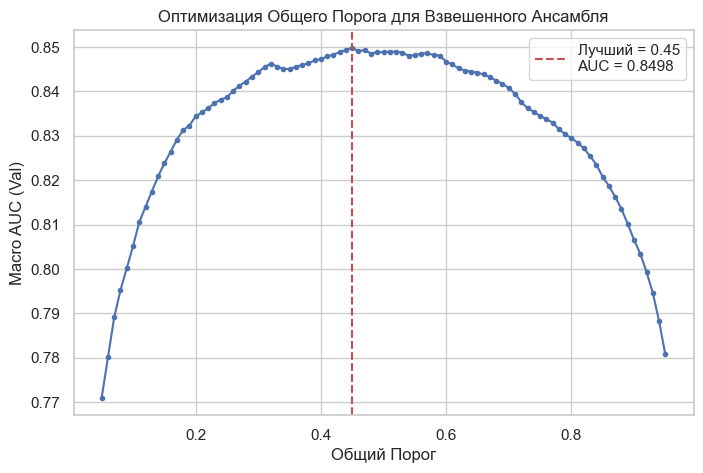


4. Получение предсказаний на ТЕСТЕ от каждой модели ансамбля...

  Обработка теста для: tfidf_mlp


Общий прогресс:   0%|          | 0/7392 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
# --- Вспомогательные функции для получения предсказаний ---

def get_bert_predictions_from_trainer(model_path, hf_dataset, device, model_key_for_config, default_bert_batch_size, num_workers):
    """Получает предсказания от BERT-подобной модели с использованием Trainer."""
    _compute_metrics_fn = globals().get('compute_metrics', None)
    
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    
    # Генерация уникального имени для временной папки
    safe_model_key_str = str(model_key_for_config).replace('/', '_')
    temp_output_dir = f"./temp_predict_dir_{safe_model_key_str}_{np.random.randint(100000)}"

    trainer_args = TrainingArguments(
        output_dir=temp_output_dir,
        per_device_eval_batch_size=globals().get(str(model_key_for_config).upper() + '_BATCH_SIZE', default_bert_batch_size) * 2,
        report_to="none",
        dataloader_num_workers=num_workers,
        disable_tqdm=True,
        logging_steps=1_000_000,
        eval_strategy="no", 
    )
    trainer = Trainer(model=model, args=trainer_args, compute_metrics=_compute_metrics_fn)
    
    predictions_output = trainer.predict(hf_dataset)
    probas = 1 / (1 + np.exp(-predictions_output.predictions))
    
    if os.path.exists(temp_output_dir):
        shutil.rmtree(temp_output_dir)
        
    del model, trainer_args, trainer, predictions_output
    return probas

def get_pytorch_model_predictions(model_instance, dataloader, device, model_type_hint):
    """Получает предсказания от обычной PyTorch модели (MLP, RNN, CNN)."""
    model_instance.eval()
    all_probas_list = []
    with torch.no_grad():
        for batch_data in tqdm(dataloader, desc=f"Infer: {model_instance.__class__.__name__}", leave=False):
            if model_type_hint == 'rnn':
                sequences, _, lengths = batch_data
                outputs = model_instance(sequences.to(device), lengths)
            elif model_type_hint == 'cnn':
                sequences, _, _ = batch_data
                outputs = model_instance(sequences.to(device))
            else:  # 'mlp'
                features, _ = batch_data
                outputs = model_instance(features.to(device))
            all_probas_list.append(torch.sigmoid(outputs).cpu().numpy())
    return np.concatenate(all_probas_list, axis=0)

MODELS_FOR_ENSEMBLE = ['tfidf_mlp']
# Возможные ключи: "tfidf_mlp", "w2v_lstm", "cnn_emb", "rnn_emb",
# "bert_tiny", "w2v_lstm_augmented", "hybrid_tfidf_bert_mlp", "berta_classifier_v1", "berta_classifier_v2"

ensemble_name_suffix = "_".join(sorted(MODELS_FOR_ENSEMBLE)) + "_WEIGHTED_GLOBAL_THR"
SUBMISSION_FILENAME = f"submission_ensemble_{ensemble_name_suffix}.csv"

print(f"Создание ансамбля из моделей: {MODELS_FOR_ENSEMBLE}")
print(f"Используемое устройство: {device}") # 'device' должен быть определен глобально

# --- Шаг 1: Получение предсказаний (вероятностей) на ВАЛИДАЦИИ от каждой модели ---
print("\n1. Получение предсказаний на ВАЛИДАЦИИ от каждой модели ансамбля...")
all_val_probas_list = []

if 'y_val_final' not in globals(): raise NameError("y_val_final (метки валидации) не найден!")
val_targets_np = y_val_final
val_targets_for_auc_tensor = torch.from_numpy(val_targets_np).float()
print(f"Размер ожидаемых меток валидации (y_val_final): {val_targets_np.shape}")

for model_key in MODELS_FOR_ENSEMBLE:
    print(f"\n  Обработка валидации для: {model_key}")
    model_path = MODEL_PATHS[model_key]
    if not os.path.exists(model_path):
         raise FileNotFoundError(f"Файл или папка модели не найдены: {model_path} для {model_key}")
    
    current_val_probas_np = None

    if model_key in ["bert_tiny", "berta_classifier_v1", "berta_classifier_v2"]: # BERT-подобные модели
        _current_hf_val_dataset = None
        if model_key == "bert_tiny":
            if 'tokenized_val_dataset' not in globals(): raise NameError("tokenized_val_dataset для bert_tiny не найден!")
            _current_hf_val_dataset = tokenized_val_dataset
        elif model_key == "berta_classifier_v1":
            if 'tokenized_val_dataset_berta_v1' in globals():
                 _current_hf_val_dataset = tokenized_val_dataset_berta_v1
            elif 'tokenized_val_dataset_berta' in globals():
                 _current_hf_val_dataset = tokenized_val_dataset_berta
            else:
                raise NameError(f"tokenized_val_dataset_berta (или _v2) для {model_key} не найден!")
        elif model_key == "berta_classifier_v2":
            if 'tokenized_val_dataset_berta_v2' not in globals():
                raise NameError(f"tokenized_val_dataset_berta_v2 для {model_key} не найден!")
            _current_hf_val_dataset = tokenized_val_dataset_berta_v2
            
            # model_path будет MODEL_PATHS["berta_classifier_v2"]
            current_val_probas_np = get_bert_predictions_from_trainer(
                model_path, 
                _current_hf_val_dataset, 
                device, 
                model_key, # Передаем сам ключ
                globals().get('BERTA_V2_BATCH_SIZE_PER_DEVICE', globals().get('BERT_FEATURE_EXTRACTOR_BATCH_SIZE', 16)), # Используем специфичный батч или дефолт
                NUM_WORKERS_ENSEMBLE_TEST
            )
        
        current_val_probas_np = get_bert_predictions_from_trainer(
            model_path, _current_hf_val_dataset, device, model_key, 
            globals().get('BERT_BATCH_SIZE', 16), NUM_WORKERS_ENSEMBLE_TEST
        )
    else: # Другие PyTorch модели (MLP, LSTM, CNN, Hybrid)
        model_instance = None
        current_val_loader = None
        model_type_hint = '' # 'mlp', 'rnn', 'cnn'

        # Предполагается, что все переменные (val_loader_tfidf, INPUT_DIM и т.д.) определены глобально
        if model_key == "tfidf_mlp":
            if 'val_loader_tfidf' not in globals(): raise NameError("val_loader_tfidf не определен!")
            current_val_loader = val_loader_tfidf
            model_instance = SimpleMLP(INPUT_DIM, HIDDEN_DIM_MLP, OUTPUT_DIM).to(device)
            model_type_hint = 'mlp'
        elif model_key == "w2v_lstm":
            if 'val_seq_loader' not in globals(): raise NameError("val_seq_loader не определен!")
            current_val_loader = val_seq_loader
            model_instance = LSTMClassifier(VOCAB_SIZE, W2V_VECTOR_SIZE, LSTM_HIDDEN_DIM, OUTPUT_DIM, LSTM_LAYERS, LSTM_BIDIRECTIONAL, LSTM_DROPOUT, PAD_IDX).to(device)
            model_type_hint = 'rnn'
        elif model_key == "cnn_emb":
            if 'val_seq_loader' not in globals(): raise NameError("val_seq_loader не определен!")
            current_val_loader = val_seq_loader
            model_instance = TextCNN(VOCAB_SIZE, CNN_EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, CNN_DROPOUT, PAD_IDX).to(device)
            model_type_hint = 'cnn'
        elif model_key == "rnn_emb":
            if 'val_seq_loader' not in globals(): raise NameError("val_seq_loader не определен!")
            current_val_loader = val_seq_loader
            model_instance = LSTMClassifierTrainableEmb(VOCAB_SIZE, RNN_TE_EMBEDDING_DIM, RNN_TE_HIDDEN_DIM, OUTPUT_DIM, RNN_TE_LAYERS, RNN_TE_BIDIRECTIONAL, RNN_TE_DROPOUT, PAD_IDX).to(device)
            model_type_hint = 'rnn'
        elif model_key == "w2v_lstm_augmented":
            if 'val_seq_loader_for_aug_model' not in globals(): raise NameError("val_seq_loader_for_aug_model не определен!")
            current_val_loader = val_seq_loader_for_aug_model
            model_instance = LSTMClassifier(VOCAB_SIZE_AUG, W2V_VECTOR_SIZE_AUG, LSTM_HIDDEN_DIM_AUG, OUTPUT_DIM, LSTM_LAYERS_AUG, LSTM_BIDIRECTIONAL_AUG, LSTM_DROPOUT_AUG, PAD_IDX_AUG).to(device)
            model_type_hint = 'rnn'
        elif model_key == "hybrid_tfidf_bert_mlp":
            if 'val_loader_hybrid' not in globals(): raise NameError("val_loader_hybrid не определен!")
            current_val_loader = val_loader_hybrid
            model_instance = SimpleMLP(COMBINED_FEATURE_DIM, HYBRID_MLP_HIDDEN_DIM, OUTPUT_DIM).to(device)
            model_type_hint = 'mlp'
        else:
            raise ValueError(f"Логика загрузки для валидации модели {model_key} не определена.")

        model_instance.load_state_dict(torch.load(model_path, map_location=device))
        current_val_probas_np = get_pytorch_model_predictions(model_instance, current_val_loader, device, model_type_hint)
        del model_instance

    if current_val_probas_np is None:
        raise RuntimeError(f"Не удалось получить val_preds_proba для {model_key}")
    if current_val_probas_np.shape[0] != val_targets_np.shape[0]:
        raise ValueError(f"Размер val_preds_proba ({current_val_probas_np.shape[0]}) для {model_key} не совпадает с val_targets ({val_targets_np.shape[0]})")
    
    all_val_probas_list.append(current_val_probas_np)
    print(f"  Вероятности для {model_key} на валидации получены: {current_val_probas_np.shape}")
    
    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

if len(all_val_probas_list) != len(MODELS_FOR_ENSEMBLE):
    raise RuntimeError("Не удалось получить предсказания для ВСЕХ моделей ансамбля на валидации.")
val_probas_stack_np = np.array(all_val_probas_list)

# --- Шаг 2: Подбор оптимальных весов ансамбля на валидации ---
print("\n2. Подбор оптимальных весов ансамбля на валидации...")
# calculate_auc должна быть определена глобально
def roc_auc_for_weighted_ensemble(weights, probas_stack, targets_tensor_for_auc, global_threshold=0.5):
    weighted_probas = np.tensordot(np.array(weights), probas_stack, axes=([0],[0]))
    # При оптимизации весов, используем вероятности напрямую или бинаризованные с фиксированным порогом.
    # Для финального AUC лучше использовать вероятности, но для оптимизации весов с порогом - бинаризованные.
    # Оригинальный код использовал бинаризованные.
    preds_binary = (weighted_probas >= global_threshold).astype(int)
    auc_score = calculate_auc(targets_tensor_for_auc, torch.from_numpy(preds_binary).float())
    return -auc_score # Минимизируем отрицательный AUC

num_models_in_ensemble = len(MODELS_FOR_ENSEMBLE)
initial_weights = np.array([1.0 / num_models_in_ensemble] * num_models_in_ensemble)
bounds_weights = [(0.0, 1.0)] * num_models_in_ensemble # Веса от 0 до 1
constraints_weights = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}) # Сумма весов равна 1

print(f"  Запуск оптимизации весов для {num_models_in_ensemble} моделей...")
optimization_result = minimize(
    roc_auc_for_weighted_ensemble, initial_weights,
    args=(val_probas_stack_np, val_targets_for_auc_tensor, 0.5), # Оптимизируем с порогом 0.5
    method='SLSQP', bounds=bounds_weights, constraints=constraints_weights,
    options={'disp': False, 'ftol': 1e-7, 'maxiter': 200 + num_models_in_ensemble * 50}
)

if optimization_result.success:
    best_ensemble_weights = np.clip(optimization_result.x, 0, 1)
    if np.sum(best_ensemble_weights) < 1e-6 : # Если все веса близки к нулю
        best_ensemble_weights = initial_weights
        print("  Оптимизация дала нулевые веса, используем равные веса.")
    else:
        best_ensemble_weights = best_ensemble_weights / np.sum(best_ensemble_weights) # Нормализуем
    print(f"  Оптимальные веса ансамбля: {best_ensemble_weights}")
else:
    print(f"  Оптимизация весов не удалась. Используем равные веса.")
    best_ensemble_weights = initial_weights

auc_at_optimal_weights_thr05 = -roc_auc_for_weighted_ensemble(best_ensemble_weights, val_probas_stack_np, val_targets_for_auc_tensor, 0.5)
print(f"  AUC на валидации с выбранными весами (и глоб. порогом 0.5): {auc_at_optimal_weights_thr05:.4f}")
weighted_avg_val_proba_np = np.tensordot(best_ensemble_weights, val_probas_stack_np, axes=([0],[0]))

# --- Шаг 3: Оптимизация ОДНОГО ОБЩЕГО порога для взвешенных вероятностей ансамбля ---
print("\n3. Оптимизация ОБЩЕГО порога для взвешенных вероятностей ансамбля...")
best_global_threshold_ensemble = 0.5
best_val_auc_for_global_threshold = -1.0
auc_by_global_threshold_ensemble = []
thresholds_to_check_global = np.arange(0.05, 0.96, 0.01) # Диапазон порогов

for threshold_val in tqdm(thresholds_to_check_global, desc="Optimizing Global Ensemble Threshold"):
    val_preds_binary_ensemble = (weighted_avg_val_proba_np >= threshold_val).astype(int)
    current_auc_ensemble = calculate_auc(val_targets_for_auc_tensor, torch.from_numpy(val_preds_binary_ensemble).float())
    auc_by_global_threshold_ensemble.append(current_auc_ensemble)
    if current_auc_ensemble > best_val_auc_for_global_threshold:
        best_val_auc_for_global_threshold = current_auc_ensemble
        best_global_threshold_ensemble = threshold_val

print(f"\nОптимальный ОБЩИЙ порог для ансамбля: {best_global_threshold_ensemble:.2f}")
print(f"Итоговый Macro AUC на валидации (с опт. весами и опт. ОБЩИМ порогом): {best_val_auc_for_global_threshold:.4f}")

plt.figure(figsize=(8,5))
plt.plot(thresholds_to_check_global, auc_by_global_threshold_ensemble, marker='.')
plt.xlabel("Общий Порог")
plt.ylabel("Macro AUC (Val)")
plt.title(f"Оптимизация Общего Порога для Взвешенного Ансамбля")
plt.grid(True)
plt.axvline(best_global_threshold_ensemble, color='r', linestyle='--', label=f'Лучший = {best_global_threshold_ensemble:.2f}\nAUC = {best_val_auc_for_global_threshold:.4f}')
plt.legend()
plt.show()

# --- Шаг 4: Получение предсказаний на ТЕСТЕ от каждой модели ансамбля ---
print("\n4. Получение предсказаний на ТЕСТЕ от каждой модели ансамбля...")
all_test_probas_list = []
# DATA_PATH должен быть определен глобально
test_df_orig = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
test_ids = test_df_orig['id'].tolist()
test_df_processed = test_df_orig.copy() # Копия для добавления обработанных текстов

for model_key in MODELS_FOR_ENSEMBLE:
    print(f"\n  Обработка теста для: {model_key}")
    model_path = MODEL_PATHS[model_key]
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Файл или папка модели не найдены: {model_path} для {model_key}")
    
    current_test_probas_np = None

    if model_key in ["bert_tiny", "berta_classifier_v1"]:
        _current_tokenizer_test = AutoTokenizer.from_pretrained(model_path) # Токенизатор из папки модели
        
        if 'text_cleaned_bert' not in test_df_processed.columns: # clean_text_for_bert должен быть глобальным
            test_df_processed['text_cleaned_bert'] = test_df_processed['text'].progress_apply(clean_text_for_bert)
        
        _max_len_current_bert = BERT_MAX_LEN if model_key == "bert_tiny" else BERT_MAX_LEN_BERTA # Глобальные переменные
        
        test_texts_for_bert = test_df_processed['text_cleaned_bert'].tolist()
        hg_test_dataset_current_bert = HFDataset.from_dict({'text': test_texts_for_bert})
        
        def tokenize_fn_for_test(examples): # Локальная функция для замыкания _current_tokenizer_test и _max_len_current_bert
            return _current_tokenizer_test(examples['text'], truncation=True, padding="max_length", max_length=_max_len_current_bert)
        
        tokenized_test_dataset_current_bert = hg_test_dataset_current_bert.map(
            tokenize_fn_for_test, batched=True, remove_columns=['text'], desc=f"Tokenizing Test for {model_key}"
        )
        tokenized_test_dataset_current_bert.set_format("torch")

        current_test_probas_np = get_bert_predictions_from_trainer(
            model_path, tokenized_test_dataset_current_bert, device, model_key,
            globals().get('BERT_BATCH_SIZE', 16), NUM_WORKERS_ENSEMBLE_TEST
        )
        del _current_tokenizer_test, tokenized_test_dataset_current_bert, hg_test_dataset_current_bert
    elif model_key == "berta_classifier_v2": # <--- Убедитесь, что ключ здесь соответствует вашему MODEL_PATHS
        # Токенизатор должен быть сохранен вместе с моделью berta_classifier_v2
        _current_tokenizer_test = AutoTokenizer.from_pretrained(model_path) 
        
        if 'text_cleaned_bert' not in test_df_processed.columns:
            test_df_processed['text_cleaned_bert'] = test_df_processed['text'].progress_apply(clean_text_for_bert)
        
        # Используем BERTA_V2_MAX_LEN, определенный глобально
        _max_len_current_bert = BERTA_V2_MAX_LEN 
        
        test_texts_for_bert = test_df_processed['text_cleaned_bert'].tolist()
        hg_test_dataset_current_bert = HFDataset.from_dict({'text': test_texts_for_bert})
        
        def tokenize_fn_for_test(examples):
            return _current_tokenizer_test(examples['text'], truncation=True, padding="max_length", max_length=_max_len_current_bert)
        
        tokenized_test_dataset_current_bert = hg_test_dataset_current_bert.map(
            tokenize_fn_for_test, batched=True, remove_columns=['text'], desc=f"Tokenizing Test for {model_key}"
        )
        tokenized_test_dataset_current_bert.set_format("torch")

        current_test_probas_np = get_bert_predictions_from_trainer(
            model_path, 
            tokenized_test_dataset_current_bert, 
            device, 
            model_key,
            globals().get('BERTA_V2_BATCH_SIZE_PER_DEVICE', globals().get('BERT_BATCH_SIZE', 16)), # Используем специфичный батч или дефолт
            NUM_WORKERS_ENSEMBLE_TEST
        )
        del _current_tokenizer_test, tokenized_test_dataset_current_bert, hg_test_dataset_current_bert
    
    else: # Другие PyTorch модели
        model_instance = None
        current_test_loader = None
        model_type_hint = ''
        # Все функции очистки, векторизаторы, словари и параметры моделей предполагаются глобально определенными

        if model_key == "tfidf_mlp":
            cleaned_col = 'text_cleaned_tfidf_test'
            if cleaned_col not in test_df_processed.columns:
                test_df_processed[cleaned_col] = test_df_processed['text'].progress_apply(lambda x: clean_text_for_tfidf(x, russian_stop_words))
            X_test_tfidf = tfidf_vectorizer.transform(test_df_processed[cleaned_col])
            test_dataset = TfidfDataset(X_test_tfidf, np.zeros((X_test_tfidf.shape[0], OUTPUT_DIM)))
            current_test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE_ENSEMBLE, shuffle=False, num_workers=NUM_WORKERS_ENSEMBLE_TEST)
            model_instance = SimpleMLP(INPUT_DIM, HIDDEN_DIM_MLP, OUTPUT_DIM).to(device)
            model_type_hint = 'mlp'
        
        elif model_key in ["w2v_lstm", "cnn_emb", "rnn_emb"]:
            # Используем общую очистку, но разные модели
            cleaned_col = f'text_cleaned_seq_test_{model_key}'
            if cleaned_col not in test_df_processed.columns:
                 test_df_processed[cleaned_col] = test_df_processed['text'].progress_apply(clean_text_for_sequential)
            
            test_sequences = [text_to_sequence(text, word_to_idx) for text in tqdm(test_df_processed[cleaned_col], desc=f"Test Seq ({model_key})")]
            test_dataset = SequenceDataset(test_sequences, np.zeros((len(test_sequences), OUTPUT_DIM)), MAX_LEN)
            _collate_fn = collate_fn_for_w2v_lstm if 'collate_fn_for_w2v_lstm' in globals() else None
            if _collate_fn is None and model_key != "cnn_emb":
                 print(f"Предупреждение: collate_fn_for_w2v_lstm не найден для {model_key}, используется стандартный collate_fn.")

            current_test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE_ENSEMBLE, shuffle=False, collate_fn=_collate_fn, num_workers=NUM_WORKERS_ENSEMBLE_TEST)

            if model_key == "w2v_lstm":
                model_instance = LSTMClassifier(VOCAB_SIZE, W2V_VECTOR_SIZE, LSTM_HIDDEN_DIM, OUTPUT_DIM, LSTM_LAYERS, LSTM_BIDIRECTIONAL, LSTM_DROPOUT, PAD_IDX).to(device)
                model_type_hint = 'rnn'
            elif model_key == "cnn_emb":
                model_instance = TextCNN(VOCAB_SIZE, CNN_EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, CNN_DROPOUT, PAD_IDX).to(device)
                model_type_hint = 'cnn'
            elif model_key == "rnn_emb":
                model_instance = LSTMClassifierTrainableEmb(VOCAB_SIZE, RNN_TE_EMBEDDING_DIM, RNN_TE_HIDDEN_DIM, OUTPUT_DIM, RNN_TE_LAYERS, RNN_TE_BIDIRECTIONAL, RNN_TE_DROPOUT, PAD_IDX).to(device)
                model_type_hint = 'rnn'

        elif model_key == "w2v_lstm_augmented":
            cleaned_col = 'text_cleaned_seq_test_aug'
            if cleaned_col not in test_df_processed.columns:
                test_df_processed[cleaned_col] = test_df_processed['text'].progress_apply(clean_text_for_sequential)
            
            test_sequences_aug = [text_to_sequence(text, word_to_idx_aug) for text in tqdm(test_df_processed[cleaned_col], desc=f"Test Seq ({model_key})")]
            # MAX_LEN_AUG или MAX_LEN? Оригинал использовал MAX_LEN. Уточнить, если есть MAX_LEN_AUG.
            _max_len_aug = globals().get('MAX_LEN_AUG', MAX_LEN) 
            test_dataset_aug = SequenceDataset(test_sequences_aug, np.zeros((len(test_sequences_aug), OUTPUT_DIM)), _max_len_aug)
            # collate_fn_for_augmented_lstm должен быть определен глобально
            if 'collate_fn_for_augmented_lstm' not in globals(): raise NameError("collate_fn_for_augmented_lstm не определен!")
            current_test_loader = DataLoader(test_dataset_aug, batch_size=TEST_BATCH_SIZE_ENSEMBLE, shuffle=False, collate_fn=collate_fn_for_augmented_lstm, num_workers=NUM_WORKERS_ENSEMBLE_TEST)
            model_instance = LSTMClassifier(VOCAB_SIZE_AUG, W2V_VECTOR_SIZE_AUG, LSTM_HIDDEN_DIM_AUG, OUTPUT_DIM, LSTM_LAYERS_AUG, LSTM_BIDIRECTIONAL_AUG, LSTM_DROPOUT_AUG, PAD_IDX_AUG).to(device)
            model_type_hint = 'rnn'

        elif model_key == "hybrid_tfidf_bert_mlp":
            cleaned_col_tfidf = 'text_cleaned_tfidf_hybrid_test'
            if cleaned_col_tfidf not in test_df_processed.columns:
                test_df_processed[cleaned_col_tfidf] = test_df_processed['text'].progress_apply(lambda x: clean_text_for_tfidf(x, russian_stop_words))
            X_test_tfidf_h = tfidf_vectorizer.transform(test_df_processed[cleaned_col_tfidf])
            
            cleaned_col_bert = 'text_cleaned_bert_hybrid_test'
            if cleaned_col_bert not in test_df_processed.columns:
                test_df_processed[cleaned_col_bert] = test_df_processed['text'].progress_apply(clean_text_for_bert)
            test_bert_texts_h = test_df_processed[cleaned_col_bert].tolist()
            
            # Глобальные: bert_feature_extractor, tokenizer_bert_features, get_bert_embeddings
            if not all(k in globals() for k in ['bert_feature_extractor', 'tokenizer_bert_features', 'get_bert_embeddings']):
                raise NameError("Компоненты для гибридной модели (BERT features) не найдены.")
            X_test_bert_h_np = get_bert_embeddings(test_bert_texts_h, tokenizer_bert_features, bert_feature_extractor, device, BERT_MAX_LEN_HYBRID_FEATURES, batch_size=globals().get('BERT_BATCH_SIZE',16))
            X_test_combined_h = sparse_hstack([X_test_tfidf_h, csr_matrix(X_test_bert_h_np)], format='csr')
            
            test_dataset_h = TfidfDataset(X_test_combined_h, np.zeros((X_test_combined_h.shape[0], OUTPUT_DIM)))
            current_test_loader = DataLoader(test_dataset_h, batch_size=TEST_BATCH_SIZE_ENSEMBLE, shuffle=False, num_workers=NUM_WORKERS_ENSEMBLE_TEST)
            model_instance = SimpleMLP(COMBINED_FEATURE_DIM, HYBRID_MLP_HIDDEN_DIM, OUTPUT_DIM).to(device)
            model_type_hint = 'mlp'
        else:
            raise ValueError(f"Логика загрузки для ТЕСТА модели {model_key} не определена.")

        model_instance.load_state_dict(torch.load(model_path, map_location=device))
        current_test_probas_np = get_pytorch_model_predictions(model_instance, current_test_loader, device, model_type_hint)
        del model_instance

    if current_test_probas_np is None:
        raise RuntimeError(f"Не удалось получить test_preds_proba для {model_key}")
    if current_test_probas_np.shape[0] != len(test_ids):
        raise ValueError(f"Размер предсказаний теста ({current_test_probas_np.shape[0]}) для {model_key} не совпадает с test_ids ({len(test_ids)})!")
    
    all_test_probas_list.append(current_test_probas_np)
    print(f"  Вероятности для {model_key} на тесте получены: {current_test_probas_np.shape}")
    
    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

if len(all_test_probas_list) != len(MODELS_FOR_ENSEMBLE):
    raise RuntimeError("Не удалось получить предсказания для ВСЕХ моделей ансамбля на тесте.")
test_probas_stack_np = np.array(all_test_probas_list)

# --- Шаг 5: Применение оптимальных весов к тестовым вероятностям ---
print("\n5. Применение оптимальных весов к тестовым вероятностям...")
weighted_avg_test_proba_np = np.tensordot(best_ensemble_weights, test_probas_stack_np, axes=([0],[0]))
print(f"Форма взвешенных тестовых вероятностей: {weighted_avg_test_proba_np.shape}")

# --- Шаг 6: Формирование сабмита с оптимальным ОБЩИМ порогом ---
print(f"\n6. Формирование файла сабмита для ансамбля с оптимальными весами и ОБЩИМ порогом {best_global_threshold_ensemble:.2f}...")
final_preds_binary_ensemble_test = (weighted_avg_test_proba_np >= best_global_threshold_ensemble).astype(int)
pred_strings_ensemble_test = [" ".join(map(str, row)) for row in final_preds_binary_ensemble_test]
submission_df_final_ensemble = pd.DataFrame({'id': test_ids, 'labels': pred_strings_ensemble_test})

if submission_df_final_ensemble.shape[0] == sample_submission_df.shape[0] and \
   list(submission_df_final_ensemble.columns) == list(sample_submission_df.columns):
    print(f"Формат сабмита (взвешенный ансамбль с общим опт. порогом) корректен. Размер: {submission_df_final_ensemble.shape}")
    submission_df_final_ensemble.to_csv(SUBMISSION_FILENAME, index=False)
    print(f"Файл сабмита сохранен как: {SUBMISSION_FILENAME}")
else:
    print("Ошибка: Формат или размер сабмита (взвешенный ансамбль) не соответствует sample_submission!")

print("\nПроцесс ансамблирования (с оптимизацией весов и ОБЩЕГО порога) и генерации сабмита завершен.")

Не у всех моделей успел добавить взвешивание классов, не все комбинации для ансамблей попробовал, а так довольно много всего сделал \
Грустно что моделька на 5 минут дольше обучалась, а так бы на прайвате и паблике 2 место занял \
ещё было бы классно последний блок кода в функцию обернуть, но для прототипирования и этого достаточно \
Лучшая модель: ансамбль tfidf_mlp + w2v_lstm + berta_classifier_v2